In [4]:
#we load the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

quarters = ['2023_Q1', '2023_Q3', '2023_Q4',
            '2024_Q2', '2024_Q4',
            '2025_Q1', '2025_Q2']
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller


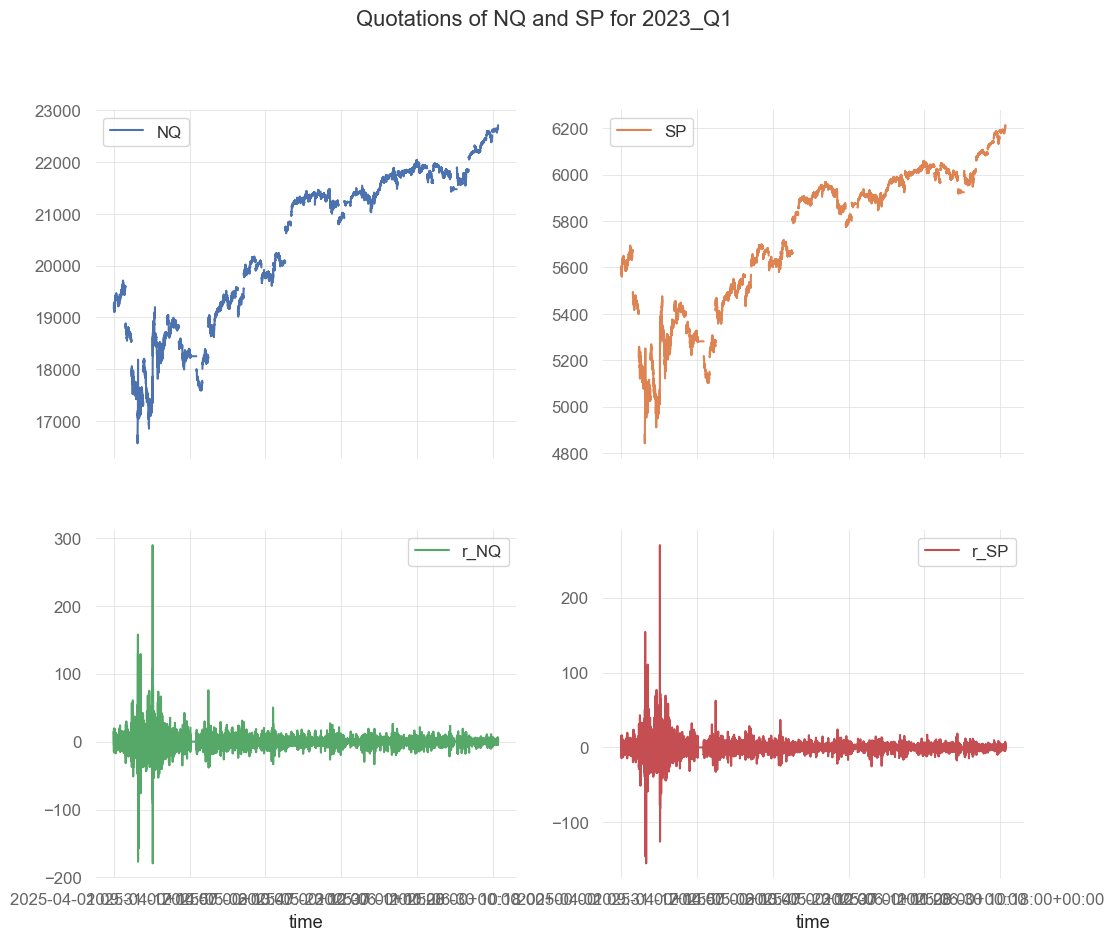

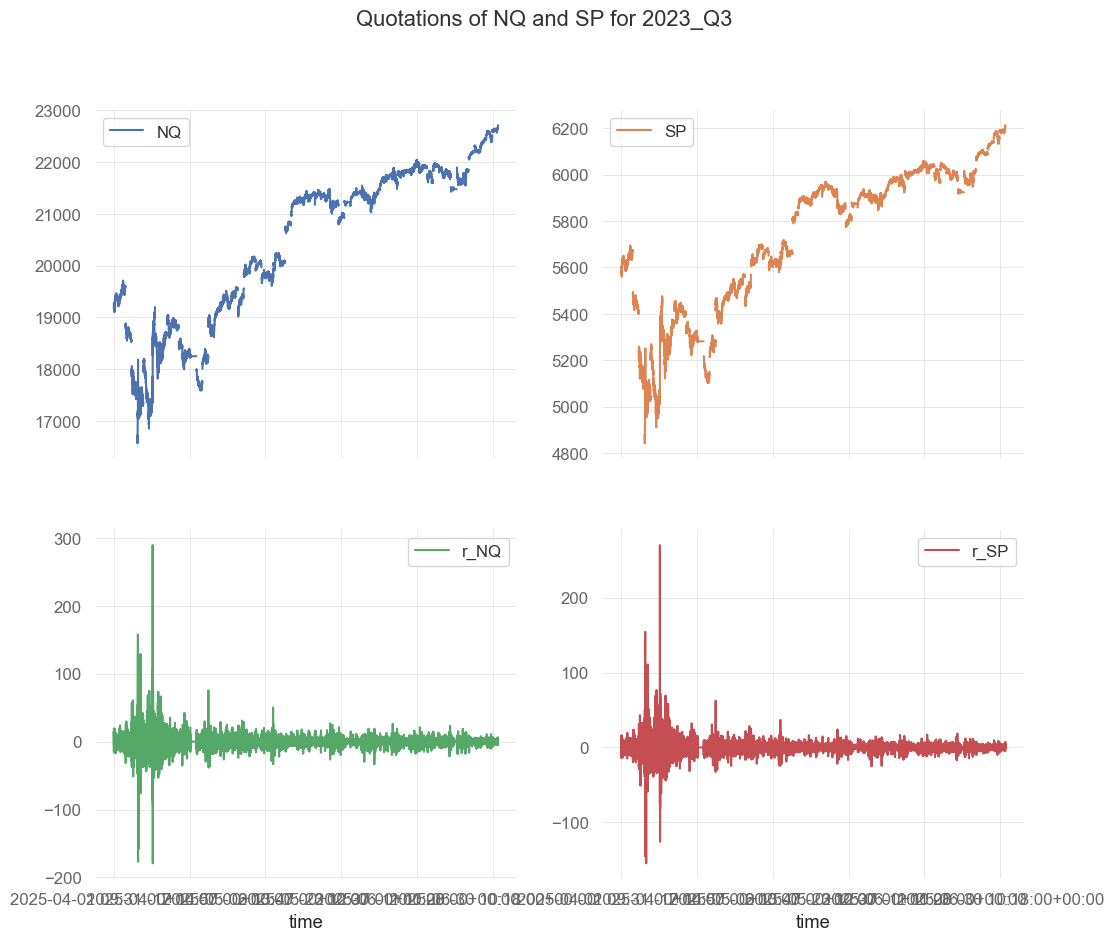

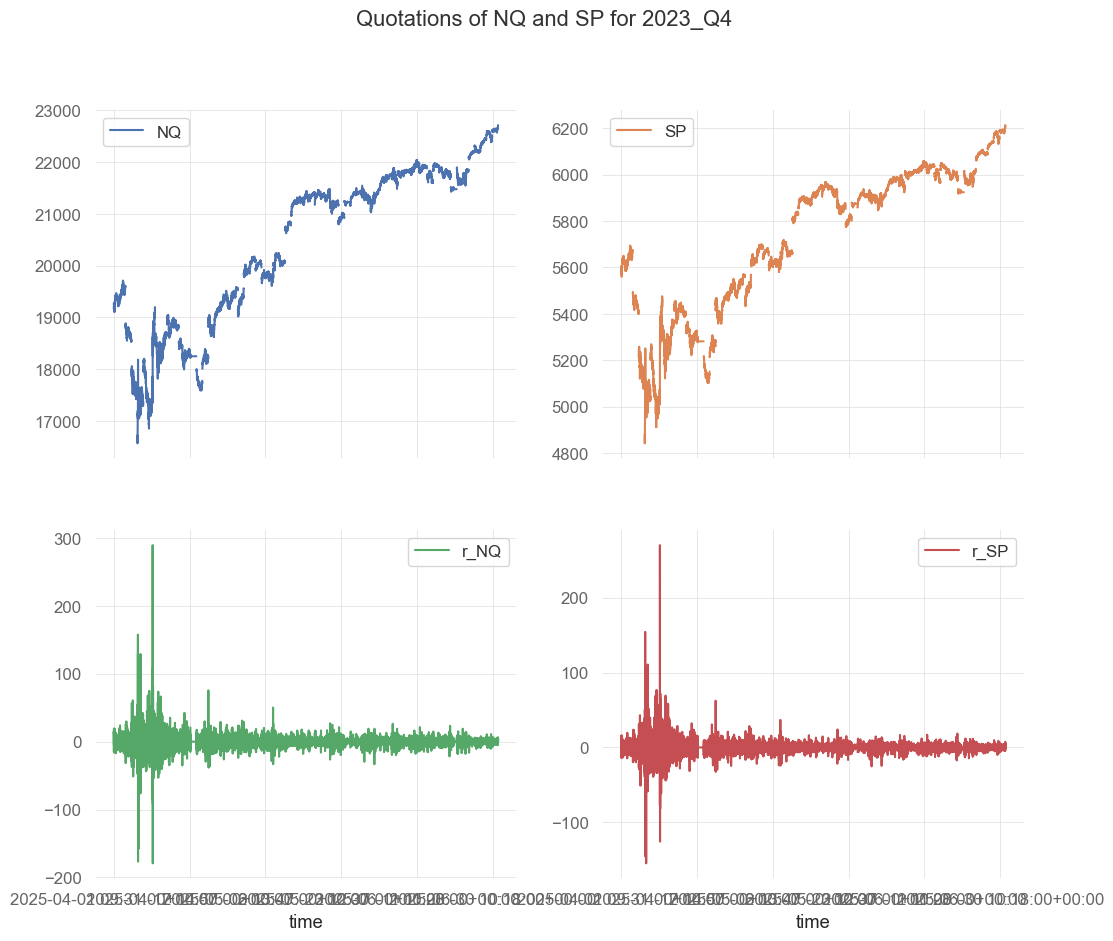

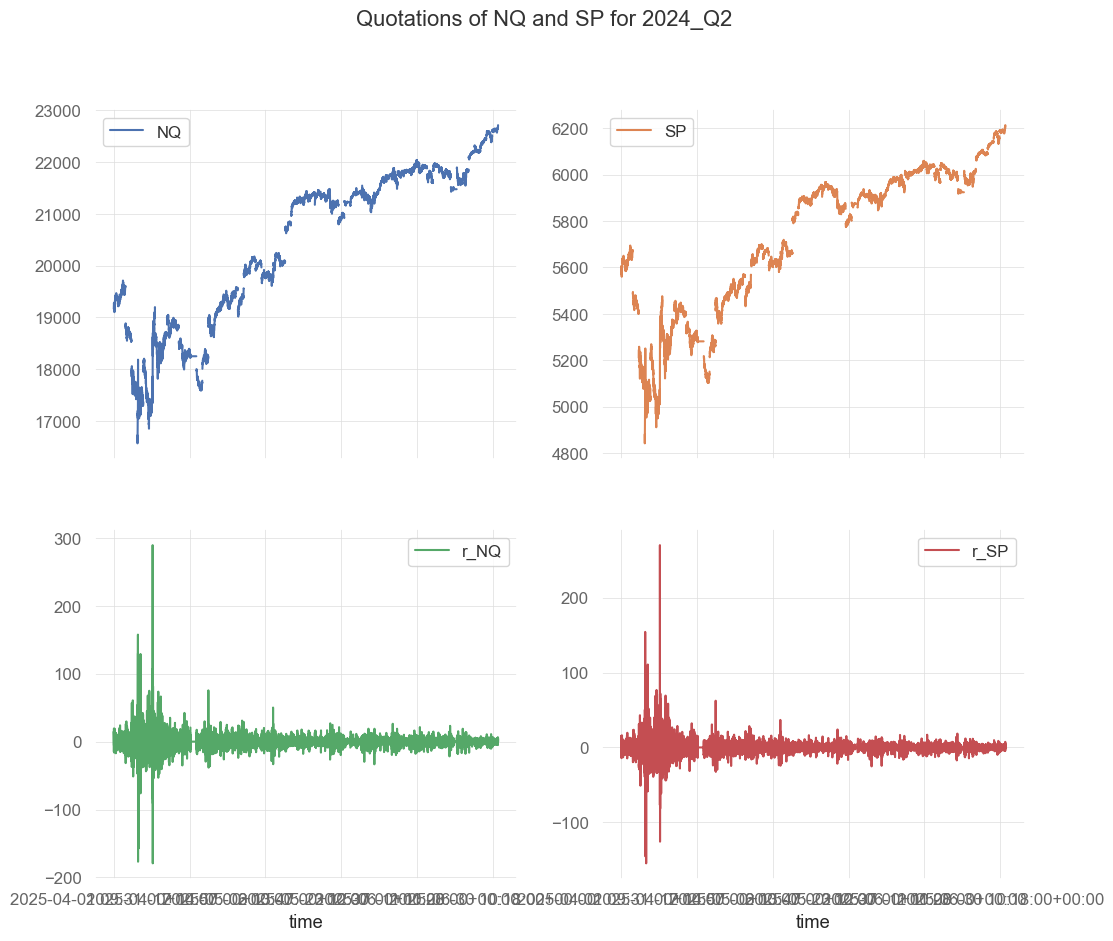

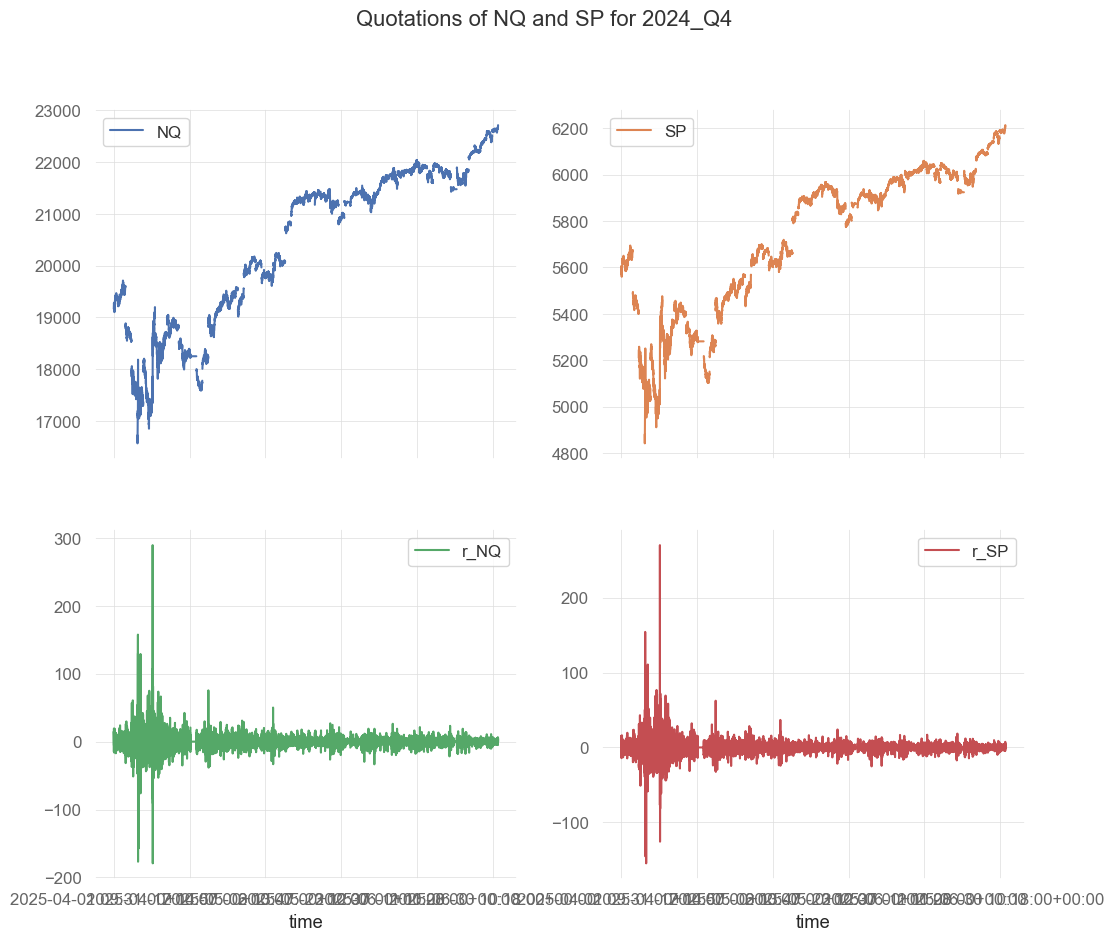

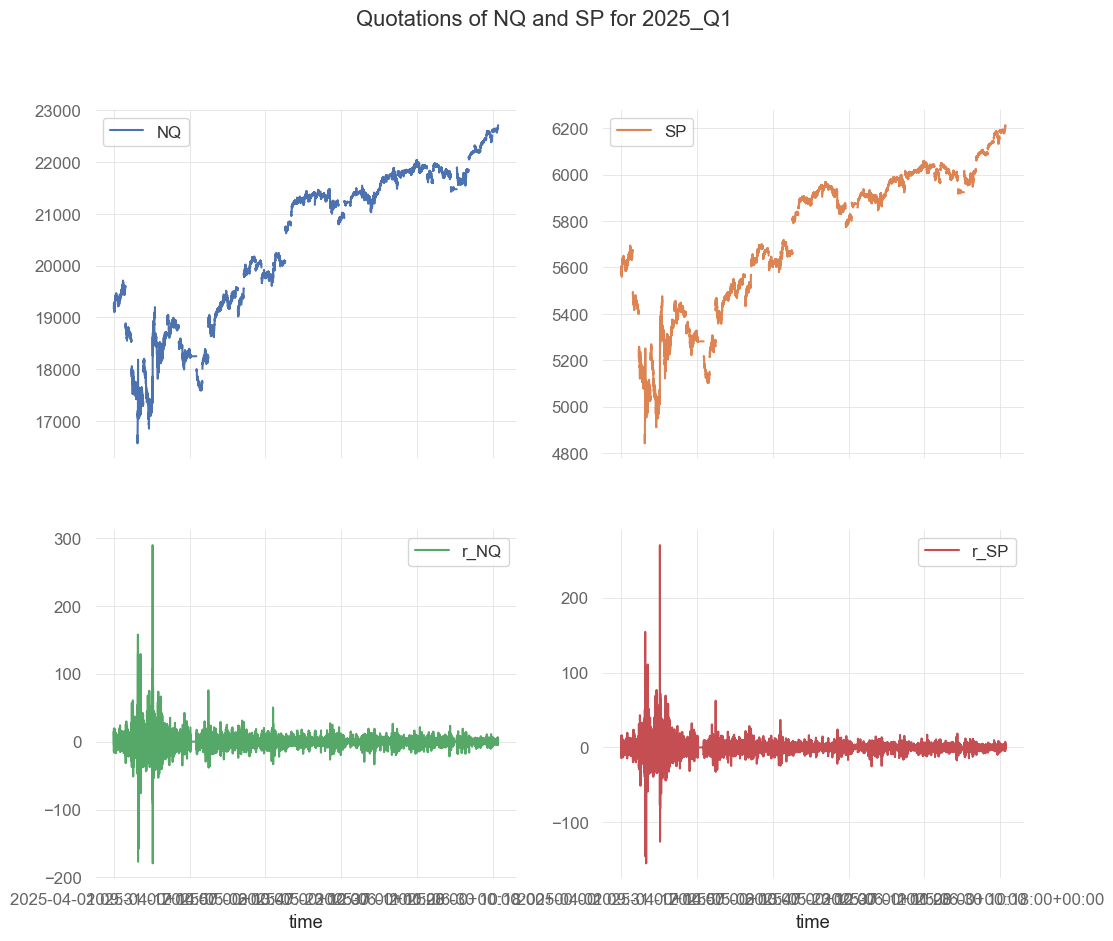

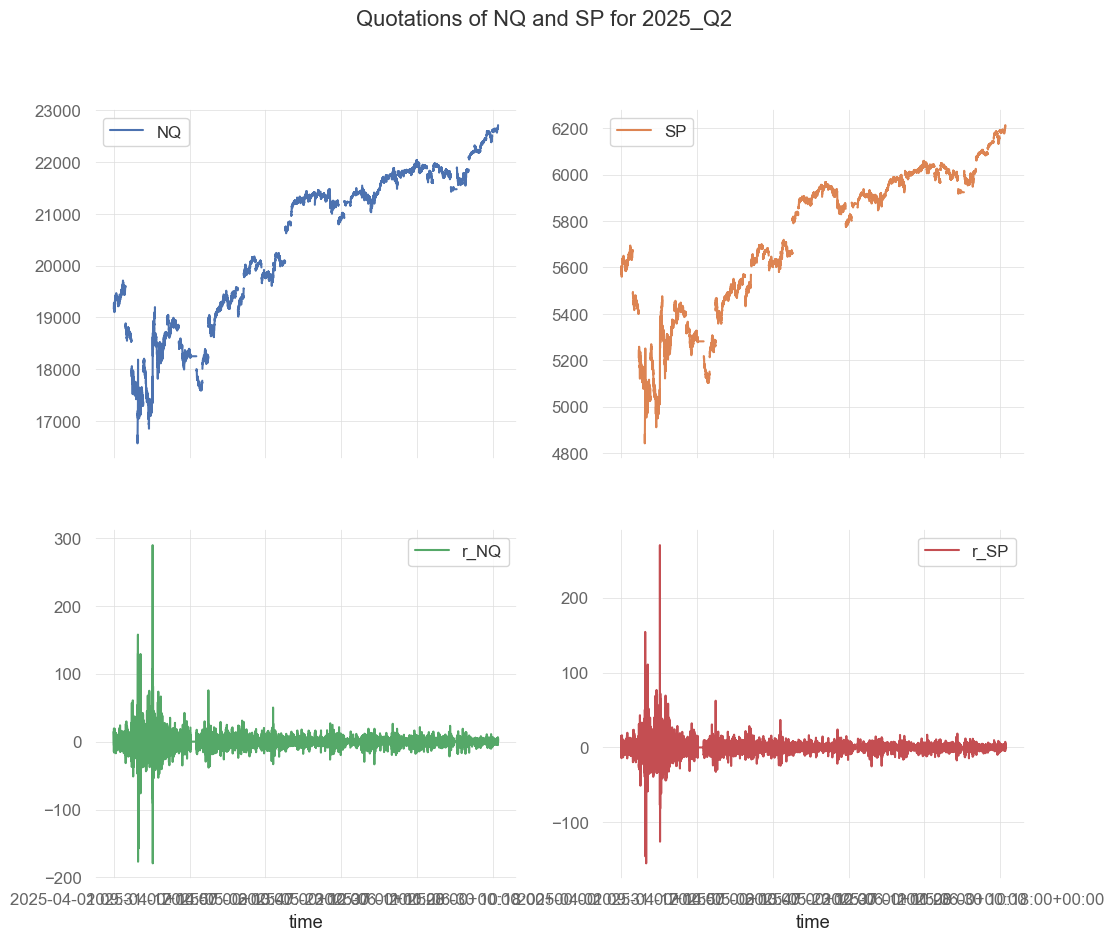

Combined data saved to 'data/all_quarters_data.parquet'
Total rows: 175812

Data summary:
quarter
2023_Q1    25109
2023_Q3    25148
2023_Q4    24952
2024_Q2    25342
2024_Q4    25350
2025_Q1    24568
2025_Q2    25343
dtype: int64

First few rows:
                           NQ  SP  r_NQ  r_SP  quarter
datetime                                              
2023-01-02 09:31:00+00:00 NaN NaN   NaN   NaN  2023_Q1
2023-01-02 09:32:00+00:00 NaN NaN   NaN   NaN  2023_Q1
2023-01-02 09:33:00+00:00 NaN NaN   NaN   NaN  2023_Q1
2023-01-02 09:34:00+00:00 NaN NaN   NaN   NaN  2023_Q1
2023-01-02 09:35:00+00:00 NaN NaN   NaN   NaN  2023_Q1

Last few rows:
                           NQ  SP  r_NQ  r_SP  quarter
datetime                                              
2025-06-30 15:56:00+00:00 NaN NaN   NaN   NaN  2025_Q2
2025-06-30 15:57:00+00:00 NaN NaN   NaN   NaN  2025_Q2
2025-06-30 15:58:00+00:00 NaN NaN   NaN   NaN  2025_Q2
2025-06-30 15:59:00+00:00 NaN NaN   NaN   NaN  2025_Q2
2025-06-30 16:00:00+00

In [32]:
# Combine all quarterly data into one file with quarter identification
all_data_list = []

for quarter in quarters:
    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace=True)
    
    data_r = np.log(data1 / data1.shift(1)) * 10000
    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP_temp = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )
    
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("9:31", "9:40").index] = np.nan
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("15:51", "16:00").index] = np.nan
    
    data_NQ_SP_plot = data_NQ_SP.copy()
    data_NQ_SP_plot['time'] = data_NQ_SP_plot.index.astype(str)

    # We reset the index to make 'time' a column
    data_NQ_SP_plot = data_NQ_SP_plot.reset_index(drop = True)

    # Let's set time as the X-axis and draw the graphs
    data_NQ_SP_plot.plot(
        x = 'time',
        subplots = True,
        layout = (2, 2),
        title = "Quotations of NQ and SP for" + f" {quarter}",
        figsize = (12, 10)
    )
    plt.show()
    
    # Add quarter column
    data_NQ_SP_temp['quarter'] = quarter
    
    all_data_list.append(data_NQ_SP_temp)

# Combine all data
all_data = pd.concat(all_data_list, axis=0)

# Save to parquet file
all_data.to_parquet('data/all_quarters_data.parquet')

print(f"Combined data saved to 'data/all_quarters_data.parquet'")
print(f"Total rows: {len(all_data)}")
print(f"\nData summary:")
print(all_data.groupby('quarter').size())
print(f"\nFirst few rows:")
print(all_data.head())
print(f"\nLast few rows:")
print(all_data.tail())
    

In [6]:

# Check cointegration between NQ and SP using the Engle-Granger test

# Get the price series (not returns) for cointegration test
nq_prices = data_NQ_SP['NQ'].dropna()
sp_prices = data_NQ_SP['SP'].dropna()

nq_returns = data_NQ_SP['r_NQ'].dropna()
sp_returns = data_NQ_SP['r_SP'].dropna()

# Check stationarity of both price series using Augmented Dickey-Fuller test
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"\nStationarity Test for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"P-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print(f"Result: {name} is stationary (p <= 0.05)")
    else:
        print(f"Result: {name} is NOT stationary (p > 0.05)")

# Test stationarity of both series
check_stationarity(nq_returns, "NQ Prices")
check_stationarity(sp_returns, "SP Prices")
# Perform Engle-Granger cointegration test
coint_stat, p_value, critical_values = coint(nq_prices, sp_prices)

print(f"Cointegration Test Results for NQ and SP:")
print(f"Test Statistic: {coint_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Critical Values:")
print(f"  1%: {critical_values[0]:.4f}")
print(f"  5%: {critical_values[1]:.4f}")
print(f"  10%: {critical_values[2]:.4f}")

# Interpretation
if p_value < 0.05:
    print("\nResult: The series are cointegrated (p < 0.05)")
else:
    print("\nResult: The series are NOT cointegrated (p >= 0.05)")


Stationarity Test for NQ Prices:
ADF Statistic: -23.0665
P-value: 0.0000
Critical Values:
  1%: -3.4306
  5%: -2.8617
  10%: -2.5668
Result: NQ Prices is stationary (p <= 0.05)

Stationarity Test for SP Prices:
ADF Statistic: -23.1981
P-value: 0.0000
Critical Values:
  1%: -3.4306
  5%: -2.8617
  10%: -2.5668
Result: SP Prices is stationary (p <= 0.05)
Cointegration Test Results for NQ and SP:
Test Statistic: -4.1085
P-value: 0.0050
Critical Values:
  1%: -3.8969
  5%: -3.3364
  10%: -3.0446

Result: The series are cointegrated (p < 0.05)


In [10]:
# Calculate correlations for each quarter
correlation_results = []

for quarter in quarters:
    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace=True)
    
    data_r = np.log(data1 / data1.shift(1)) * 10000
    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP_temp = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )
    
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("9:31", "9:35").index] = np.nan
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("15:56", "16:00").index] = np.nan
    
    # Calculate correlations for this quarter
    corr_p = data_NQ_SP_temp['NQ'].corr(data_NQ_SP_temp['SP'])
    corr_r = data_NQ_SP_temp['r_NQ'].corr(data_NQ_SP_temp['r_SP'])
    
    correlation_results.append({
        'Quarter': quarter,
        'Price_Correlation': corr_p,
        'Returns_Correlation': corr_r
    })
    
    print(f"\n{quarter}:")
    print(f"NQ and SP closing price correlation: {corr_p:.4f}")
    print(f"NQ and SP returns correlation: {corr_r:.4f}")

# Create a summary dataframe
correlation_summary = pd.DataFrame(correlation_results)
print("\n" + "="*50)
print("Summary of Correlations by Quarter:")
print(correlation_summary)



2023_Q1:
NQ and SP closing price correlation: 0.6383
NQ and SP returns correlation: 0.6804

2023_Q3:
NQ and SP closing price correlation: 0.9498
NQ and SP returns correlation: 0.7654

2023_Q4:
NQ and SP closing price correlation: 0.9964
NQ and SP returns correlation: 0.9207

2024_Q2:
NQ and SP closing price correlation: 0.9879
NQ and SP returns correlation: 0.9263

2024_Q4:
NQ and SP closing price correlation: 0.9135
NQ and SP returns correlation: 0.8934

2025_Q1:
NQ and SP closing price correlation: 0.9884
NQ and SP returns correlation: 0.9537

2025_Q2:
NQ and SP closing price correlation: 0.9956
NQ and SP returns correlation: 0.9464

Summary of Correlations by Quarter:
   Quarter  Price_Correlation  Returns_Correlation
0  2023_Q1           0.638297             0.680361
1  2023_Q3           0.949790             0.765433
2  2023_Q4           0.996397             0.920750
3  2024_Q2           0.987851             0.926320
4  2024_Q4           0.913452             0.893409
5  2025_Q1   

/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/joannamisiak/Desktop/STUDIA/HFD/HFD_Trading_Competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning:

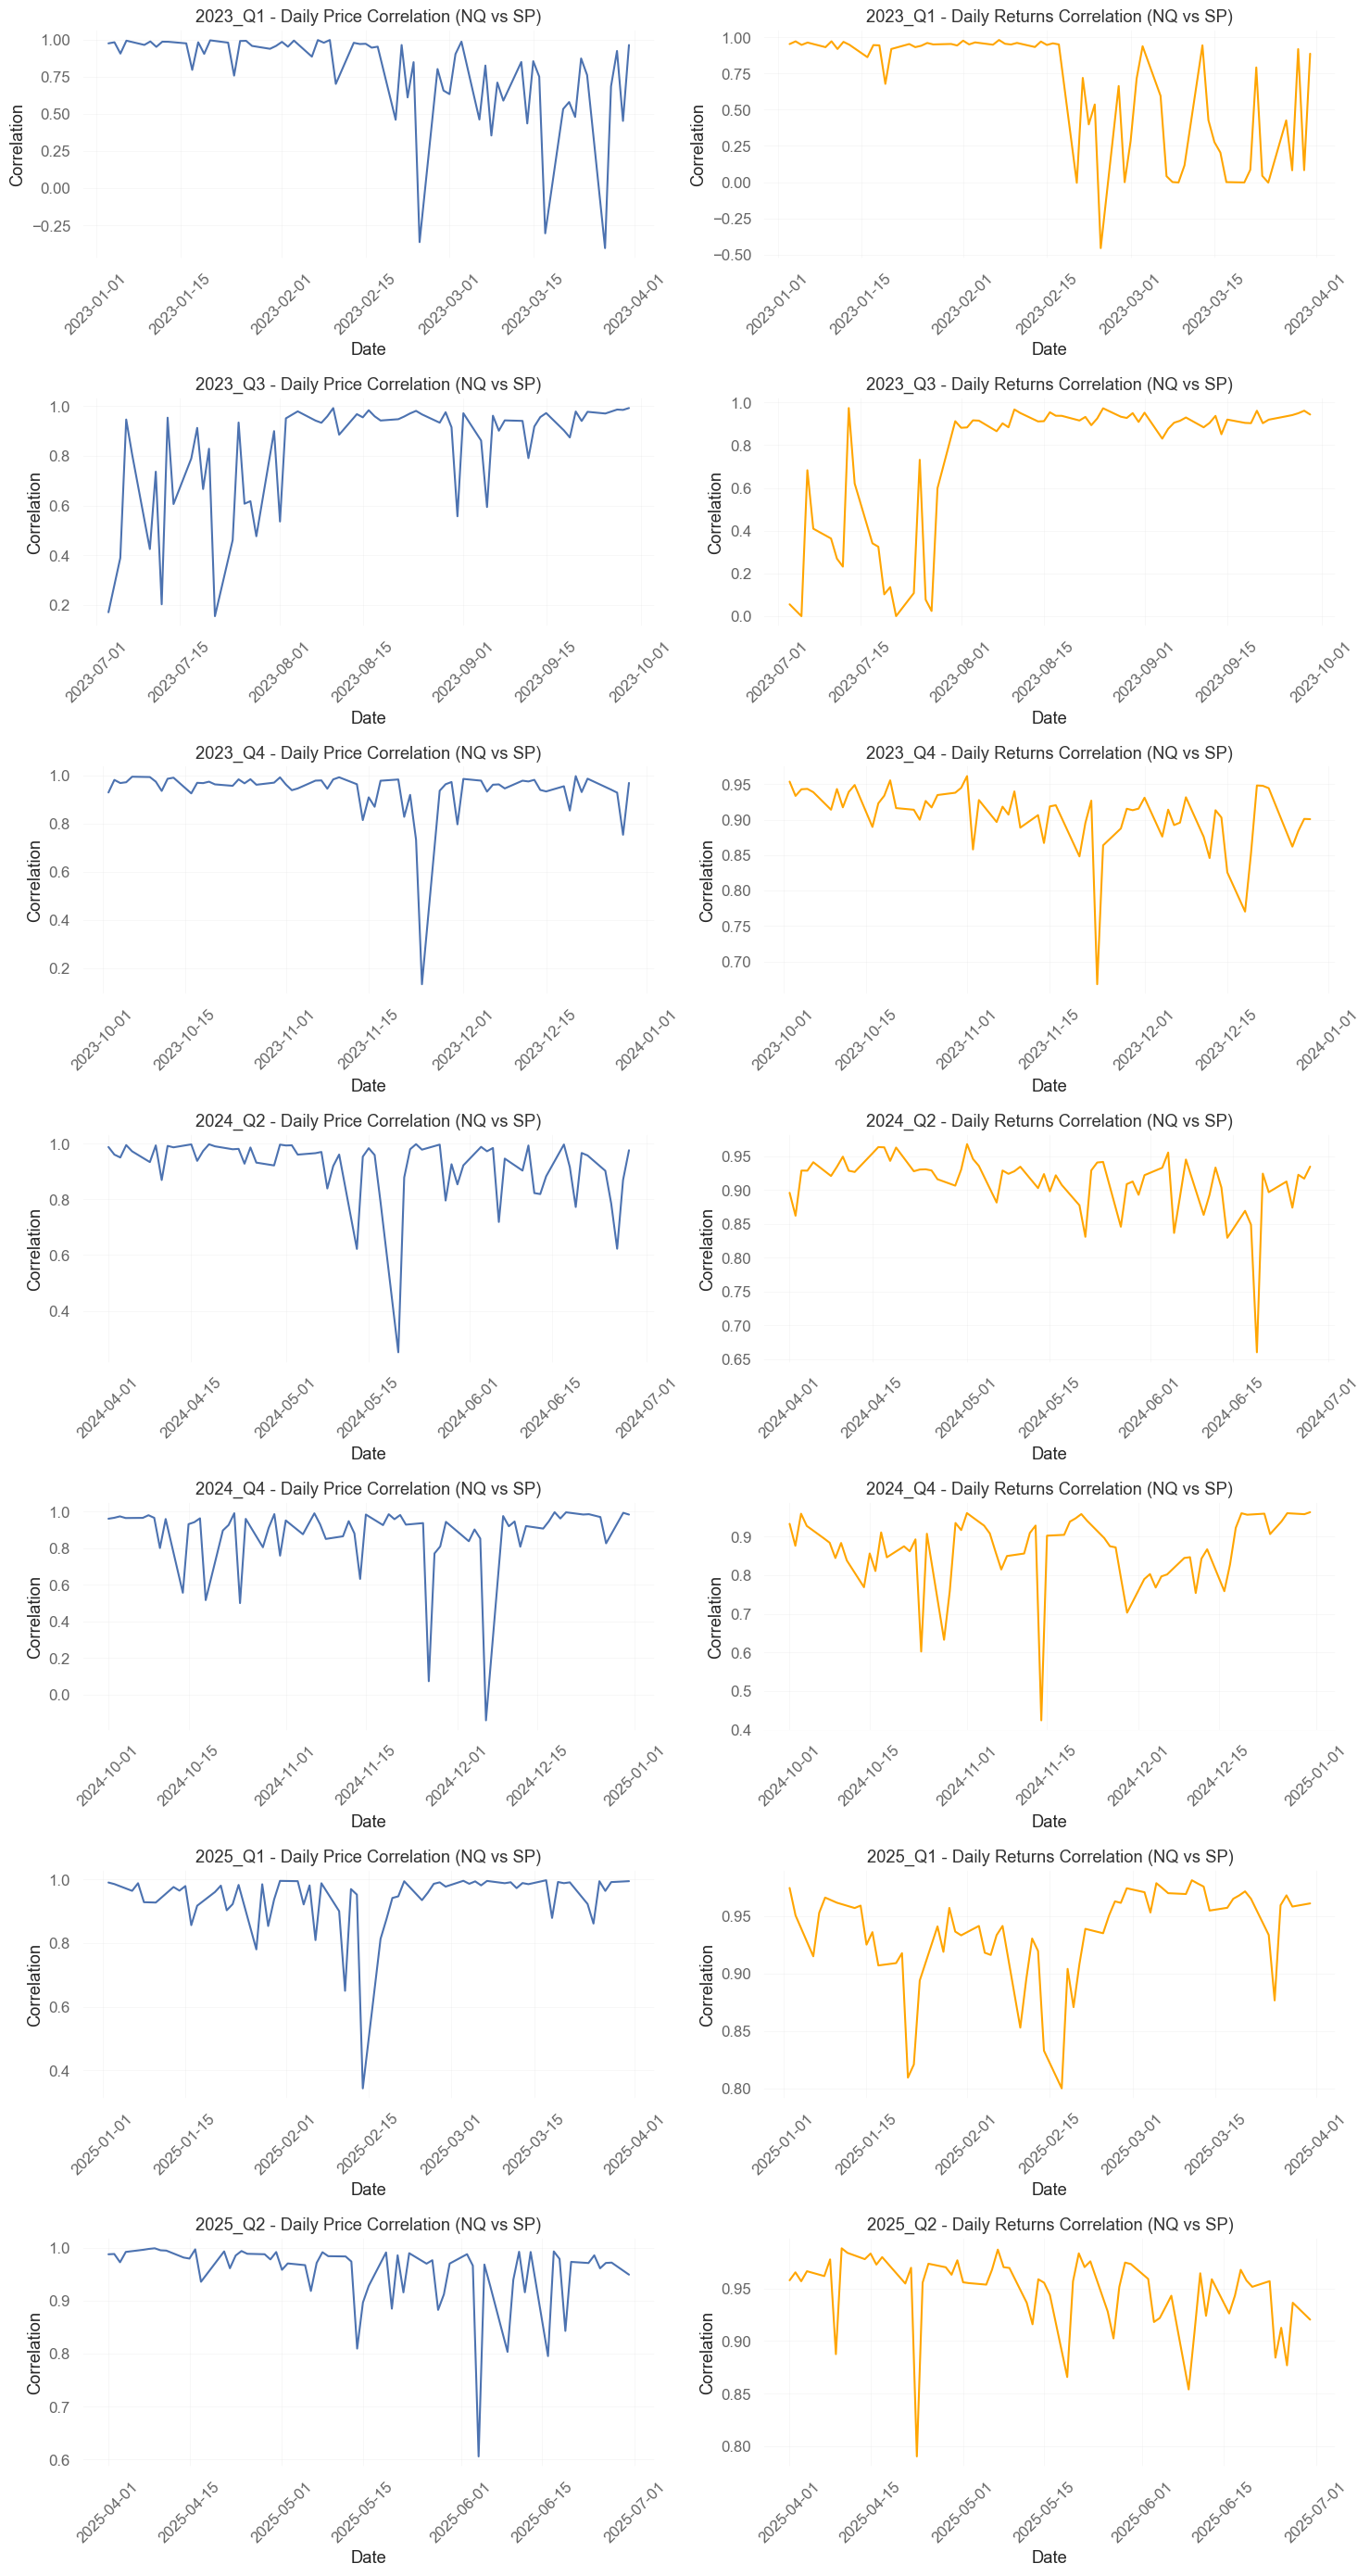

In [ ]:
# Create daily correlation charts for each quarter
fig, axes = plt.subplots(len(quarters), 2, figsize=(15, 4*len(quarters)))

for idx, quarter in enumerate(quarters):
    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace=True)
    
    data_r = np.log(data1 / data1.shift(1)) * 10000
    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP_temp = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )
    
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("9:31", "9:40").index] = np.nan
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("15:51", "16:00").index] = np.nan
    
    # Calculate daily correlations
    correlation_p_daily_q = data_NQ_SP_temp.resample("D").apply(lambda x: x['NQ'].corr(x['SP']))
    correlation_r_daily_q = data_NQ_SP_temp.resample("D").apply(lambda x: x['r_NQ'].corr(x['r_SP']))
    
    correlation_p_daily_q = correlation_p_daily_q.dropna()
    correlation_r_daily_q = correlation_r_daily_q.dropna()
    
    # Plot price correlation
    axes[idx, 0].plot(correlation_p_daily_q.index, correlation_p_daily_q.values)
    axes[idx, 0].set_title(f"{quarter} - Daily Price Correlation (NQ vs SP)")
    axes[idx, 0].set_xlabel("Date")
    axes[idx, 0].set_ylabel("Correlation")
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].tick_params(axis='x', rotation=45)
    
    # Plot returns correlation
    axes[idx, 1].plot(correlation_r_daily_q.index, correlation_r_daily_q.values, color='orange')
    axes[idx, 1].set_title(f"{quarter} - Daily Returns Correlation (NQ vs SP)")
    axes[idx, 1].set_xlabel("Date")
    axes[idx, 1].set_ylabel("Correlation")
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Spread based on Prices



All Average Ratios by Quarter:
                           av_ratio  quarter
2023-01-04 09:31:00+00:00  2.841128  2023_Q1
2023-01-05 09:31:00+00:00  2.832036  2023_Q1
2023-01-06 09:31:00+00:00  2.827369  2023_Q1
2023-01-09 09:31:00+00:00  2.826538  2023_Q1
2023-01-10 09:31:00+00:00  2.859933  2023_Q1
...                             ...      ...
2025-06-25 09:31:00+00:00  3.640806  2025_Q2
2025-06-26 09:31:00+00:00  3.648214  2025_Q2
2025-06-27 09:31:00+00:00  3.652207  2025_Q2
2025-06-30 09:31:00+00:00  3.652897  2025_Q2
2025-07-01 09:31:00+00:00  3.655372  2025_Q2

[451 rows x 2 columns]

Summary of NQ/SP Ratio by Quarter:
   Quarter  Mean_Ratio  Std_Ratio  Min_Ratio  Max_Ratio
0  2023_Q1    3.023116   0.110152   2.826538   3.217859
1  2023_Q3    3.414513   0.023675   3.359279   3.468643
2  2023_Q4    3.488637   0.030819   3.411605   3.535814
3  2024_Q2    3.522011   0.054493   3.430368   3.633050
4  2024_Q4    3.515682   0.049944   3.452093   3.636171
5  2025_Q1    3.543757   0.04736

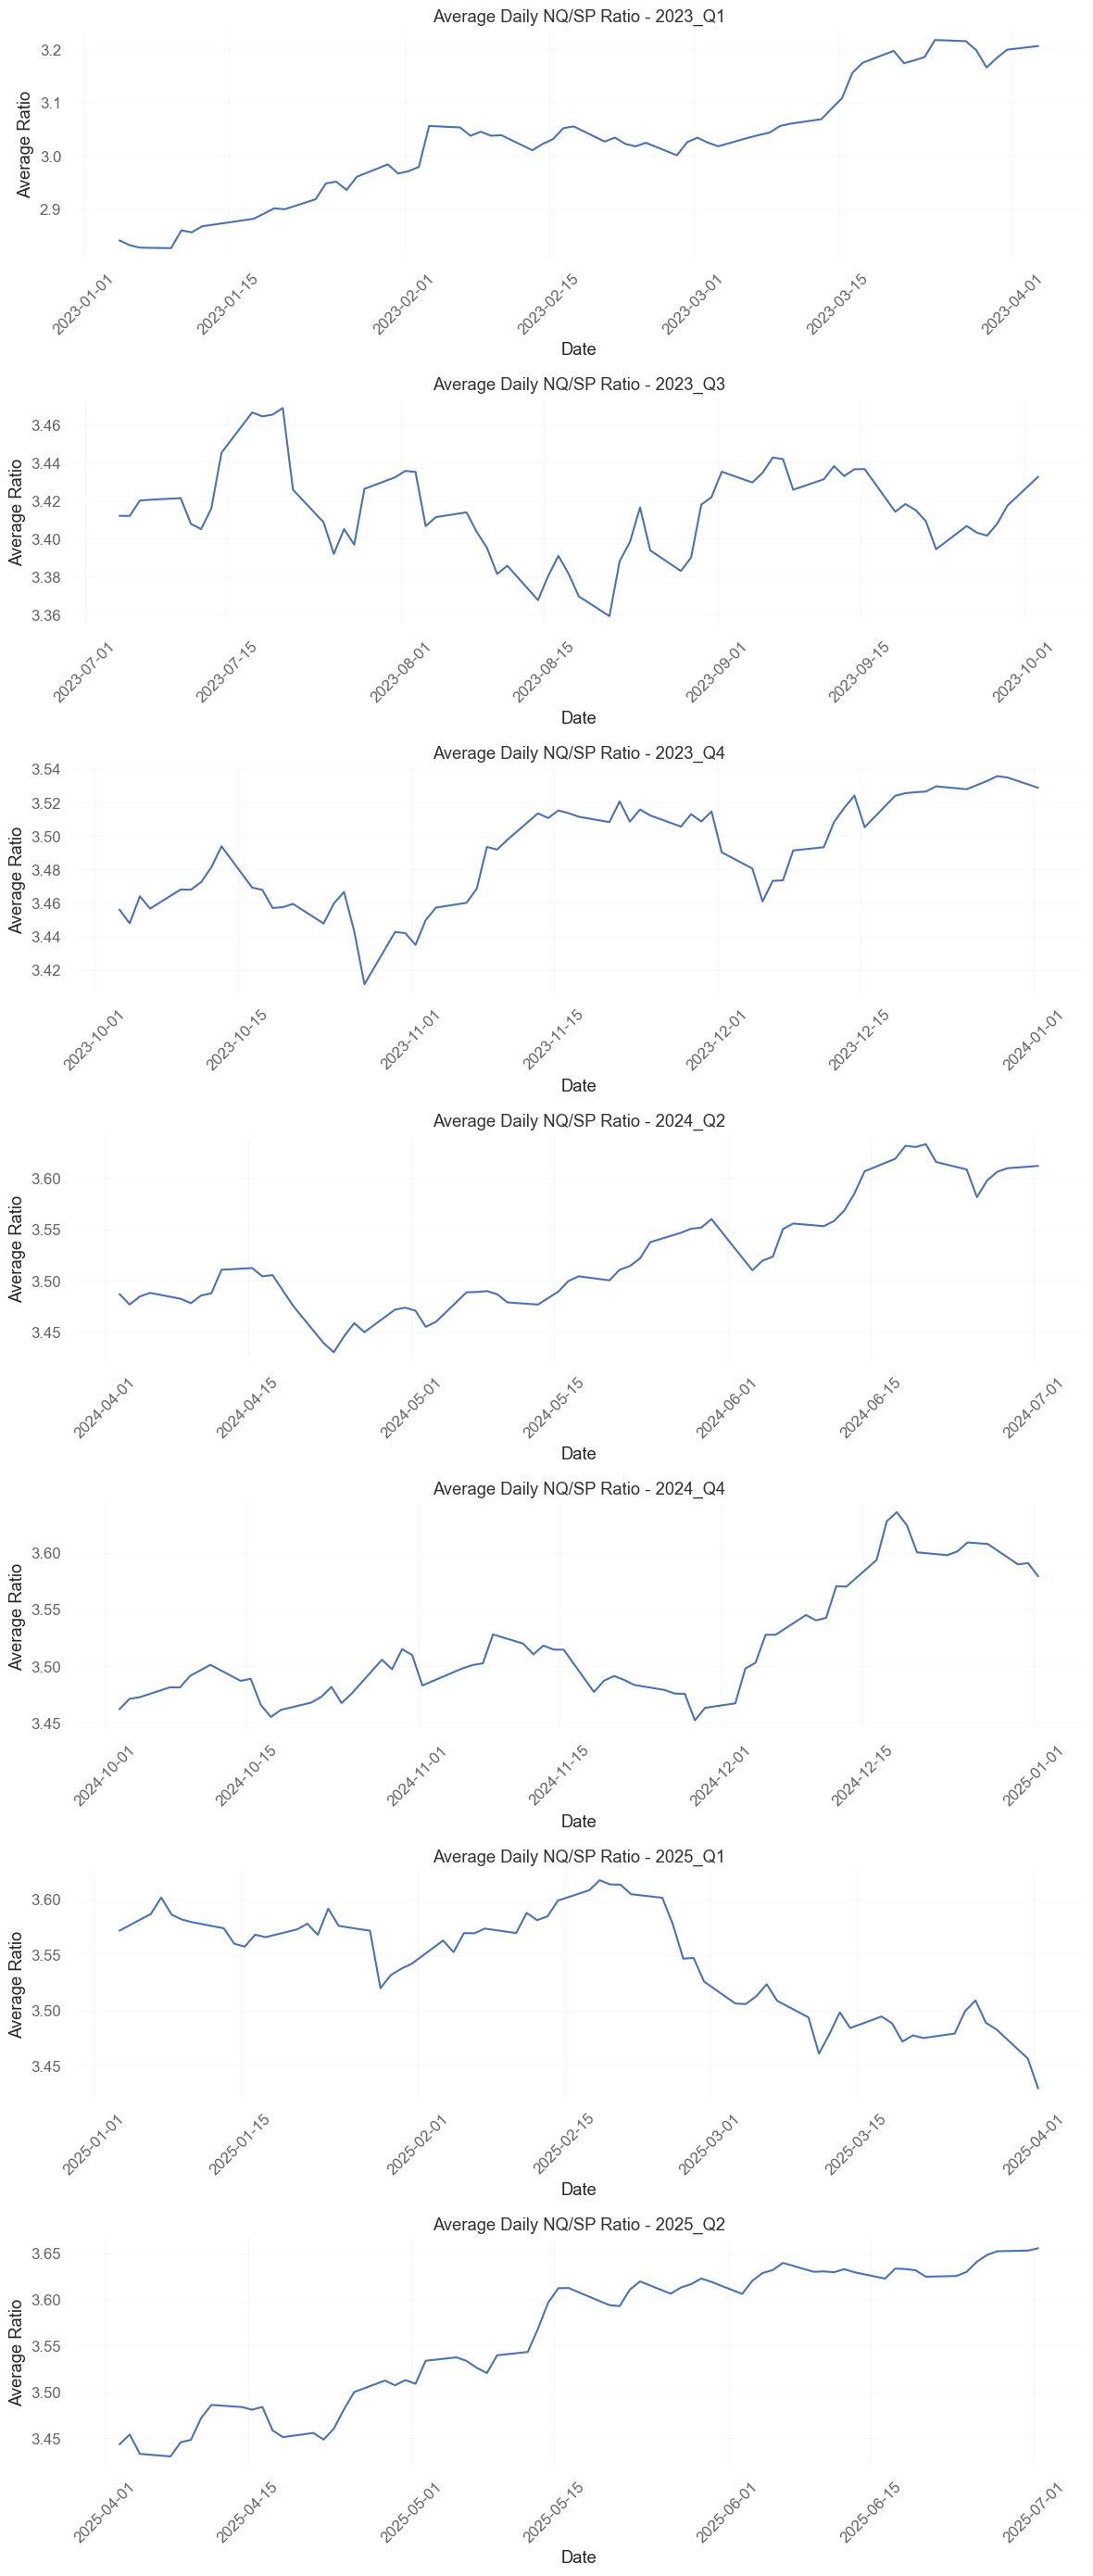

In [62]:
# Calculate the ratio for each quarter
ratio_results = []

# Initialize list to store all av_ratio data with quarter identification
all_av_ratios = []

for quarter in quarters:
    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace=True)
    
    data_r = np.log(data1 / data1.shift(1)) * 10000
    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP_temp = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )
    
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("9:31", "9:40").index] = np.nan
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("15:51", "16:00").index] = np.nan
    
    # Compute the ratio SP / NQ
    ratio_temp = data_NQ_SP_temp["NQ"] / data_NQ_SP_temp["SP"]
    
    # Compute daily averages
    av_ratio_temp = ratio_temp.resample("D").mean().dropna()
    
    # Store results
    ratio_results.append({
        'Quarter': quarter,
        'Mean_Ratio': av_ratio_temp.mean(),
        'Std_Ratio': av_ratio_temp.std(),
        'Min_Ratio': av_ratio_temp.min(),
        'Max_Ratio': av_ratio_temp.max()
    })
    
    # Store av_ratio with quarter identification
    av_ratio_quarter = av_ratio_temp.to_frame(name='av_ratio')
    av_ratio_quarter['quarter'] = quarter
    av_ratio_quarter.index = av_ratio_quarter.index + pd.to_timedelta(np.where(av_ratio_quarter.index.day_name() == "Friday", "3D", "1D")) + pd.Timedelta("9h31m")
    all_av_ratios.append(av_ratio_quarter)

# Combine all av_ratios into one DataFrame
all_av_ratios_df = pd.concat(all_av_ratios, axis=0)
print("\nAll Average Ratios by Quarter:")
print(all_av_ratios_df)

# Create summary dataframe
ratio_summary = pd.DataFrame(ratio_results)
print("\nSummary of NQ/SP Ratio by Quarter:")
print(ratio_summary)

# Create charts for each quarter
fig, axes = plt.subplots(len(quarters), 1, figsize=(12, 4*len(quarters)))

for idx, quarter in enumerate(quarters):
    quarter_data = all_av_ratios_df[all_av_ratios_df['quarter'] == quarter]
    
    axes[idx].plot(quarter_data.index, quarter_data['av_ratio'].values)
    axes[idx].set_title(f"Average Daily NQ/SP Ratio - {quarter}")
    axes[idx].set_xlabel("Date")
    axes[idx].set_ylabel("Average Ratio")
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Spread based on returns

/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_45549/437500235.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ratio_temp = data_NQ_SP_temp.resample("D").apply(lambda x: x['r_NQ'].std() / x['r_SP'].std())
/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_45549/437500235.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ratio_temp = data_NQ_SP_temp.resample("D").apply(lambda x: x['r_NQ'].std() / x['r_SP'].std())
/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_45549/437500235.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ratio_temp = data_NQ_SP_temp.resample("D").apply(lambda x: x['r_NQ'].std() / x['r_SP'].std())



All Ratios by Quarter:
                           sds_ratio  quarter
2023-01-04 09:31:00+00:00   1.279531  2023_Q1
2023-01-05 09:31:00+00:00   1.342489  2023_Q1
2023-01-06 09:31:00+00:00   1.277520  2023_Q1
2023-01-09 09:31:00+00:00   1.375531  2023_Q1
2023-01-10 09:31:00+00:00   1.382066  2023_Q1
...                              ...      ...
2025-06-25 09:31:00+00:00   1.253501  2025_Q2
2025-06-26 09:31:00+00:00   1.356833  2025_Q2
2025-06-27 09:31:00+00:00   1.363997  2025_Q2
2025-06-30 09:31:00+00:00   1.235791  2025_Q2
2025-07-01 09:31:00+00:00   1.180688  2025_Q2

[448 rows x 2 columns]

Summary of NQ/SP Ratio by Quarter:
    Quarter  Mean_Ratio  Std_Ratio  Min_Ratio  Max_Ratio
0   2023_Q1    3.023116   0.110152   2.826538   3.217859
1   2023_Q3    3.414513   0.023675   3.359279   3.468643
2   2023_Q4    3.488637   0.030819   3.411605   3.535814
3   2024_Q2    3.522011   0.054493   3.430368   3.633050
4   2024_Q4    3.515682   0.049944   3.452093   3.636171
5   2025_Q1    3.54375

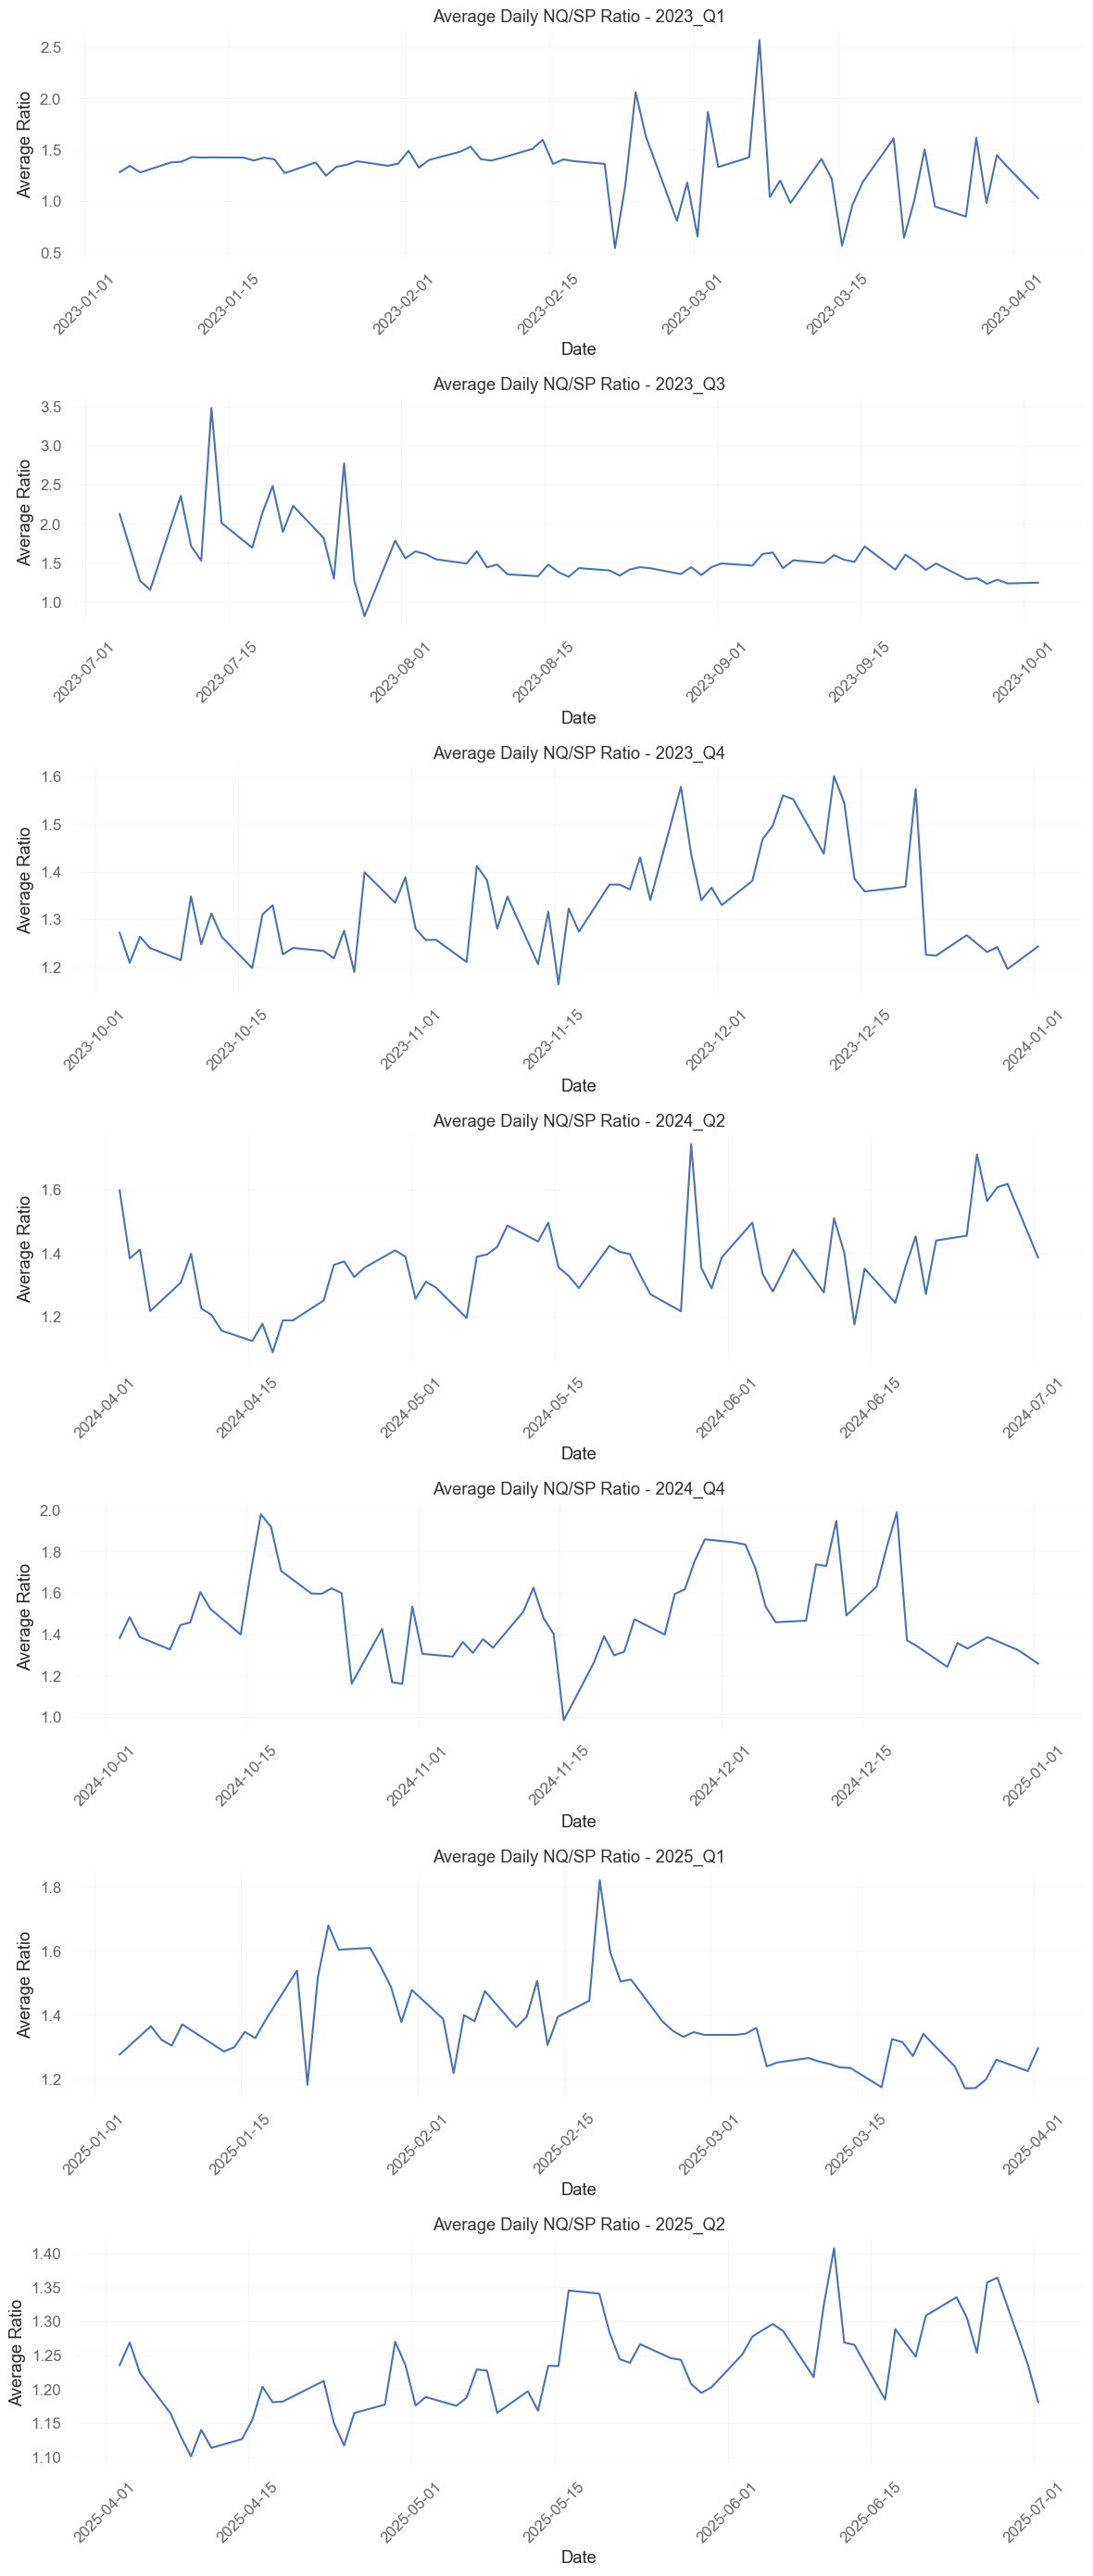

In [63]:
# Calculate the ratio for each quarter
ratio_sds_results = []

# Initialize list to store all av_ratio data with quarter identification
all_sds_ratios = []

for quarter in quarters:
    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace=True)
    
    data_r = np.log(data1 / data1.shift(1)) * 10000
    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP_temp = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )
    
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("9:31", "9:40").index] = np.nan
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("15:51", "16:00").index] = np.nan
    
    # Compute the ratio SP / NQ
    ratio_temp = data_NQ_SP_temp.resample("D").apply(lambda x: x['r_NQ'].std() / x['r_SP'].std())
    
    # Compute daily averages
    sds_ratio_temp = ratio_temp.dropna()
    
    # Store results
    ratio_results.append({
        'Quarter': quarter,
        'Mean_Ratio': sds_ratio_temp.mean(),
        'Std_Ratio': sds_ratio_temp.std(),
        'Min_Ratio': sds_ratio_temp.min(),
        'Max_Ratio': sds_ratio_temp.max()
    })
    
    # Store av_ratio with quarter identification
    sds_ratio_quarter = sds_ratio_temp.to_frame(name='sds_ratio')
    sds_ratio_quarter['quarter'] = quarter
    sds_ratio_quarter.index = sds_ratio_quarter.index + pd.to_timedelta(np.where(sds_ratio_quarter.index.day_name() == "Friday", "3D", "1D")) + pd.Timedelta("9h31m")
    all_sds_ratios.append(sds_ratio_quarter)

# Combine all av_ratios into one DataFrame
all_sds_ratios_df = pd.concat(all_sds_ratios, axis=0)
print("\nAll Ratios by Quarter:")
print(all_sds_ratios_df)

# Create summary dataframe
ratio_summary = pd.DataFrame(ratio_results)
print("\nSummary of NQ/SP Ratio by Quarter:")
print(ratio_summary)

# Create charts for each quarter
fig, axes = plt.subplots(len(quarters), 1, figsize=(12, 4*len(quarters)))

for idx, quarter in enumerate(quarters):
    quarter_data = all_sds_ratios_df[all_sds_ratios_df['quarter'] == quarter]
    
    axes[idx].plot(quarter_data.index, quarter_data['sds_ratio'].values)
    axes[idx].set_title(f"Average Daily NQ/SP Ratio - {quarter}")
    axes[idx].set_xlabel("Date")
    axes[idx].set_ylabel("Average Ratio")
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [64]:
all_data_2 = all_data.copy()
all_data_2 = all_data_2.merge(all_sds_ratios_df[['sds_ratio']], left_index=True, right_index=True, how='left')
all_data_2 = all_data_2.merge(all_av_ratios_df[['av_ratio']], left_index=True, right_index=True, how='left')

all_data_2.between_time("9:31", "9:45").head(40)

NQ        SP       r_NQ       r_SP  quarter  \
datetime                                                                        
2023-01-02 09:31:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:32:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:33:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:34:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:35:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:36:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:37:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:38:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:39:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:40:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:41:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:42:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:43:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:44:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:45:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:31:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:32:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:33:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:34:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:35:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:36:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:37:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:38:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:39:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:40:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:41:00+00:00  11076.889  3871.616  12.222087   9.698328  2023_Q1   
2023-01-03 09:42:00+00:00  11087.009  3875.631   9.131968  10.364973  2023_Q1   
2023-01-03 09:43:00+00:00  11084.699  3876.116  -2.083737   1.251331  2023_Q1   
2023-01-03 09:44:00+00:00  11082.409  3873.866  -2.066124  -5.806465  2023_Q1   
2023-01-03 09:45:00+00:00  11051.949  3867.122 -27.522840 -17.424137  2023_Q1   
2023-01-04 09:31:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:32:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:33:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:34:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:35:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:36:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:37:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:38:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:39:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:40:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   

                           sds_ratio  av_ratio  
datetime                                        
2023-01-02 09:31:00+00:00        NaN       NaN  
2023-01-02 09:32:00+00:00        NaN       NaN  
2023-01-02 09:33:00+00:00        NaN       NaN  
2023-01-02 09:34:00+00:00        NaN       NaN  
2023-01-02 09:35:00+00:00        NaN       NaN  
2023-01-02 09:36:00+00:00        NaN       NaN  
2023-01-02 09:37:00+00:00        NaN       NaN  
2023-01-02 09:38:00+00:00        NaN       NaN  
2023-01-02 09:39:00+00:00        NaN       NaN  
2023-01-02 09:40:00+00:00        NaN       NaN  
2023-01-02 09:41:00+00:00        NaN       

In [65]:
all_data_2[['av_ratio', 'sds_ratio']] = all_data_2[['av_ratio', 'sds_ratio']].ffill()
all_data_2.between_time("9:31", "9:45").head(40)

NQ        SP       r_NQ       r_SP  quarter  \
datetime                                                                        
2023-01-02 09:31:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:32:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:33:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:34:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:35:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:36:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:37:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:38:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:39:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:40:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:41:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:42:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:43:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:44:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-02 09:45:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:31:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:32:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:33:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:34:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:35:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:36:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:37:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:38:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:39:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:40:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-03 09:41:00+00:00  11076.889  3871.616  12.222087   9.698328  2023_Q1   
2023-01-03 09:42:00+00:00  11087.009  3875.631   9.131968  10.364973  2023_Q1   
2023-01-03 09:43:00+00:00  11084.699  3876.116  -2.083737   1.251331  2023_Q1   
2023-01-03 09:44:00+00:00  11082.409  3873.866  -2.066124  -5.806465  2023_Q1   
2023-01-03 09:45:00+00:00  11051.949  3867.122 -27.522840 -17.424137  2023_Q1   
2023-01-04 09:31:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:32:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:33:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:34:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:35:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:36:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:37:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:38:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:39:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   
2023-01-04 09:40:00+00:00        NaN       NaN        NaN        NaN  2023_Q1   

                           sds_ratio  av_ratio  
datetime                                        
2023-01-02 09:31:00+00:00        NaN       NaN  
2023-01-02 09:32:00+00:00        NaN       NaN  
2023-01-02 09:33:00+00:00        NaN       NaN  
2023-01-02 09:34:00+00:00        NaN       NaN  
2023-01-02 09:35:00+00:00        NaN       NaN  
2023-01-02 09:36:00+00:00        NaN       NaN  
2023-01-02 09:37:00+00:00        NaN       NaN  
2023-01-02 09:38:00+00:00        NaN       NaN  
2023-01-02 09:39:00+00:00        NaN       NaN  
2023-01-02 09:40:00+00:00        NaN       NaN  
2023-01-02 09:41:00+00:00        NaN       

In [66]:
all_data_2[all_data_2['quarter'] == '2025_Q1'].between_time("9:31", "9:45").tail(40)

NQ        SP       r_NQ       r_SP  quarter  \
datetime                                                                        
2025-03-27 09:36:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-27 09:37:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-27 09:38:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-27 09:39:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-27 09:40:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-27 09:41:00+00:00  19957.274  5726.212   2.333256   3.521272  2025_Q1   
2025-03-27 09:42:00+00:00  19961.063  5726.219   1.898376   0.012224  2025_Q1   
2025-03-27 09:43:00+00:00  19962.731  5726.495   0.835592   0.481982  2025_Q1   
2025-03-27 09:44:00+00:00  19960.288  5726.271  -1.223855  -0.391172  2025_Q1   
2025-03-27 09:45:00+00:00  19959.775  5726.318  -0.257014   0.082078  2025_Q1   
2025-03-28 09:31:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:32:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:33:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:34:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:35:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:36:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:37:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:38:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:39:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:40:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-28 09:41:00+00:00  19446.397  5615.539  -1.405303   1.180722  2025_Q1   
2025-03-28 09:42:00+00:00  19445.209  5614.713  -0.610929  -1.471027  2025_Q1   
2025-03-28 09:43:00+00:00  19458.786  5617.623   6.979746   5.181469  2025_Q1   
2025-03-28 09:44:00+00:00  19463.731  5618.855   2.540946   2.192858  2025_Q1   
2025-03-28 09:45:00+00:00  19460.885  5617.394  -1.462314  -2.600512  2025_Q1   
2025-03-31 09:31:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:32:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:33:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:34:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:35:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:36:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:37:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:38:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:39:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:40:00+00:00        NaN       NaN        NaN        NaN  2025_Q1   
2025-03-31 09:41:00+00:00  18867.398  5504.128 -11.782175 -11.998334  2025_Q1   
2025-03-31 09:42:00+00:00  18866.819  5501.745  -0.306883  -4.330415  2025_Q1   
2025-03-31 09:43:00+00:00  18873.820  5503.369   3.710059   2.951355  2025_Q1   
2025-03-31 09:44:00+00:00  18863.541  5499.872  -5.447652  -6.356309  2025_Q1   
2025-03-31 09:45:00+00:00  18825.631  5494.622 -20.117191  -9.550236  2025_Q1   

                           sds_ratio  av_ratio  
datetime                                        
2025-03-27 09:36:00+00:00   1.198211  3.488700  
2025-03-27 09:37:00+00:00   1.198211  3.488700  
2025-03-27 09:38:00+00:00   1.198211  3.488700  
2025-03-27 09:39:00+00:00   1.198211  3.488700  
2025-03-27 09:40:00+00:00   1.198211  3.488700  
2025-03-27 09:41:00+00:00   1.198211  3.488700  
2025-03-27 09:42:00+00:00   1.198211  3.488700  
2025-03-27 09:43:00+00:00   1.198211  3.488700  
2025-03-27 09:44:00+00:00   1.198211  3.488700  
2025-03-27 09:45:00+00:00   1.198211  3.488700  
2025-03-28 09:31:00+00:00   1.259899  3.482

In [67]:
all_data_2.index.day_name().value_counts()

datetime
Friday       35484
Thursday     35439
Tuesday      35362
Monday       34838
Wednesday    34689
Name: count, dtype: int64

In [79]:
all_data_2['spread_avratio'] = all_data_2['NQ'] - all_data_2['SP'] * all_data_2['av_ratio']
all_data_2['spread_sdsratio'] = all_data_2['r_NQ'] - all_data_2['r_SP'] * all_data_2['sds_ratio']

In [80]:
all_data_2.tail(40)

NQ        SP      r_NQ      r_SP  quarter  \
datetime                                                                      
2025-06-30 15:21:00+00:00  22647.220  6197.004  3.395695  4.430541  2025_Q2   
2025-06-30 15:22:00+00:00  22659.608  6199.712  5.468492  4.368899  2025_Q2   
2025-06-30 15:23:00+00:00  22657.020  6199.216 -1.142186 -0.800069  2025_Q2   
2025-06-30 15:24:00+00:00  22659.021  6199.241  0.883131  0.040328  2025_Q2   
2025-06-30 15:25:00+00:00  22660.264  6200.049  0.548552  1.303300  2025_Q2   
2025-06-30 15:26:00+00:00  22665.875  6201.504  2.475834  2.346480  2025_Q2   
2025-06-30 15:27:00+00:00  22671.064  6203.713  2.289083  3.561405  2025_Q2   
2025-06-30 15:28:00+00:00  22667.310  6203.251 -1.655992 -0.744743  2025_Q2   
2025-06-30 15:29:00+00:00  22665.119  6203.742 -0.966637  0.791489  2025_Q2   
2025-06-30 15:30:00+00:00  22658.809  6201.548 -2.784401 -3.537201  2025_Q2   
2025-06-30 15:31:00+00:00  22650.608  6198.865 -3.619998 -4.327275  2025_Q2   
2025-06-30 15:32:00+00:00  22657.731  6200.864  3.144234  3.224264  2025_Q2   
2025-06-30 15:33:00+00:00  22656.131  6200.138 -0.706186 -1.170873  2025_Q2   
2025-06-30 15:34:00+00:00  22663.297  6201.629  3.162441  2.404496  2025_Q2   
2025-06-30 15:35:00+00:00  22662.576  6201.905 -0.318141  0.445034  2025_Q2   
2025-06-30 15:36:00+00:00  22661.032  6201.185 -0.681323 -1.161001  2025_Q2   
2025-06-30 15:37:00+00:00  22657.810  6199.494 -1.421925 -2.727270  2025_Q2   
2025-06-30 15:38:00+00:00  22652.619  6197.311 -2.291305 -3.521875  2025_Q2   
2025-06-30 15:39:00+00:00  22654.253  6197.338  0.721303  0.043567  2025_Q2   
2025-06-30 15:40:00+00:00  22655.499  6197.919  0.549992  0.937455  2025_Q2   
2025-06-30 15:41:00+00:00  22670.075  6201.595  6.431689  5.929265  2025_Q2   
2025-06-30 15:42:00+00:00  22670.389  6201.419  0.138508 -0.283802  2025_Q2   
2025-06-30 15:43:00+00:00  22674.564  6202.353  1.841440  1.505994  2025_Q2   
2025-06-30 15:44:00+00:00  22677.586  6203.375  1.332682  1.647626  2025_Q2   
2025-06-30 15:45:00+00:00  22666.053  6200.426 -5.086932 -4.754994  2025_Q2   
2025-06-30 15:46:00+00:00  22668.721  6201.941  1.177021  2.443082  2025_Q2   
2025-06-30 15:47:00+00:00  22669.743  6202.694  0.450831  1.214062  2025_Q2   
2025-06-30 15:48:00+00:00  22677.831  6204.918  3.567115  3.584896  2025_Q2   
2025-06-30 15:49:00+00:00  22679.210  6206.386  0.608064  2.365585  2025_Q2   
2025-06-30 15:50:00+00:00  22678.865  6205.469 -0.152123 -1.477620  2025_Q2   
2025-06-30 15:51:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:52:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:53:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:54:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:55:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:56:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:57:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:58:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 15:59:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   
2025-06-30 16:00:00+00:00        NaN       NaN       NaN       NaN  2025_Q2   

                           sds_ratio  av_ratio  spread_avratio  \
datetime                                                         
2025-06-30 15:21:00+00:00   1.235791  3.652897       10.201896   
2025-06-30 15:22:00+00:00   1.235791  3.652897       12.697851   
2025-06-30 15:23:00+00:00   1.235791  3.652897       11.921688   
2025-06-30 15:24:00+00:00   1.235791  3.652897       13.831365   
2025-06-30 15:25:00+00:00   1.235791  3.652897       12.122824   
2025-06-30 15:26:00+00:00   1.235791  3.652897       12.418859   
2025-06-30 15:27:00+00:00   1.235791  3.652897        9.538609   
2025-06-30 15:28:00+00:00   1.235791  3.652897        7.472248   
2025-06-30 15:29:00+00:00   1.235791  3.652897        3

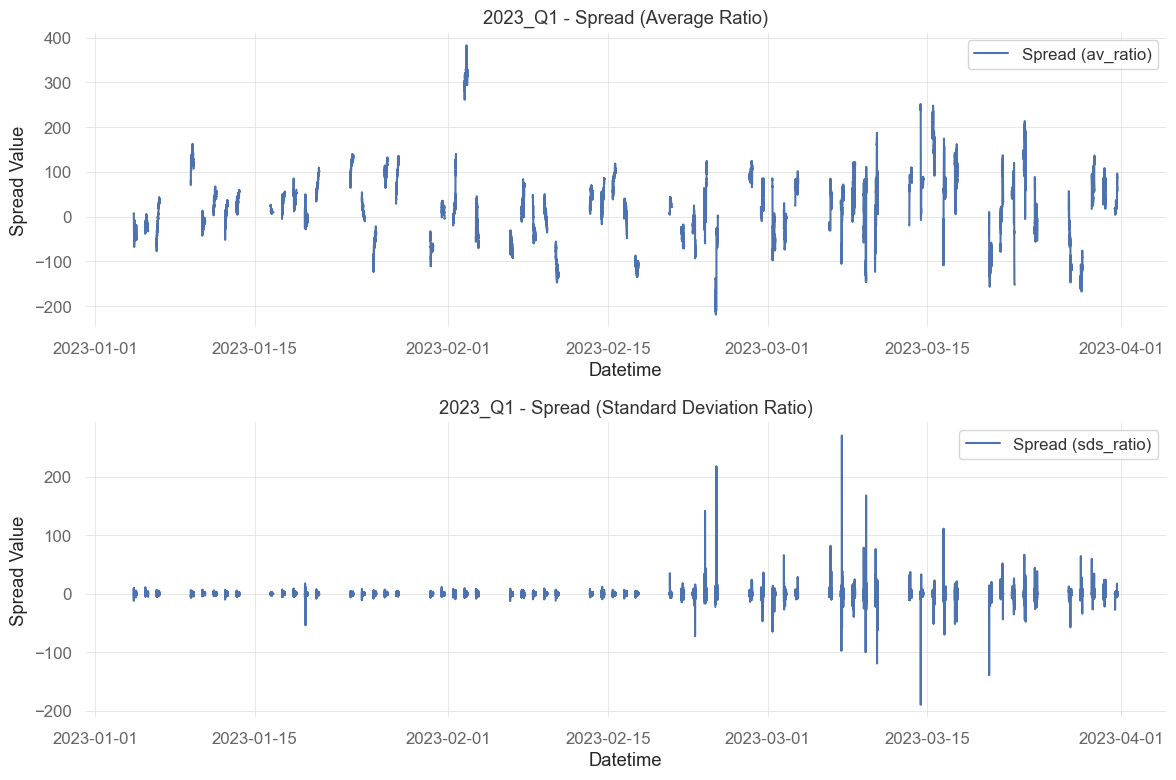

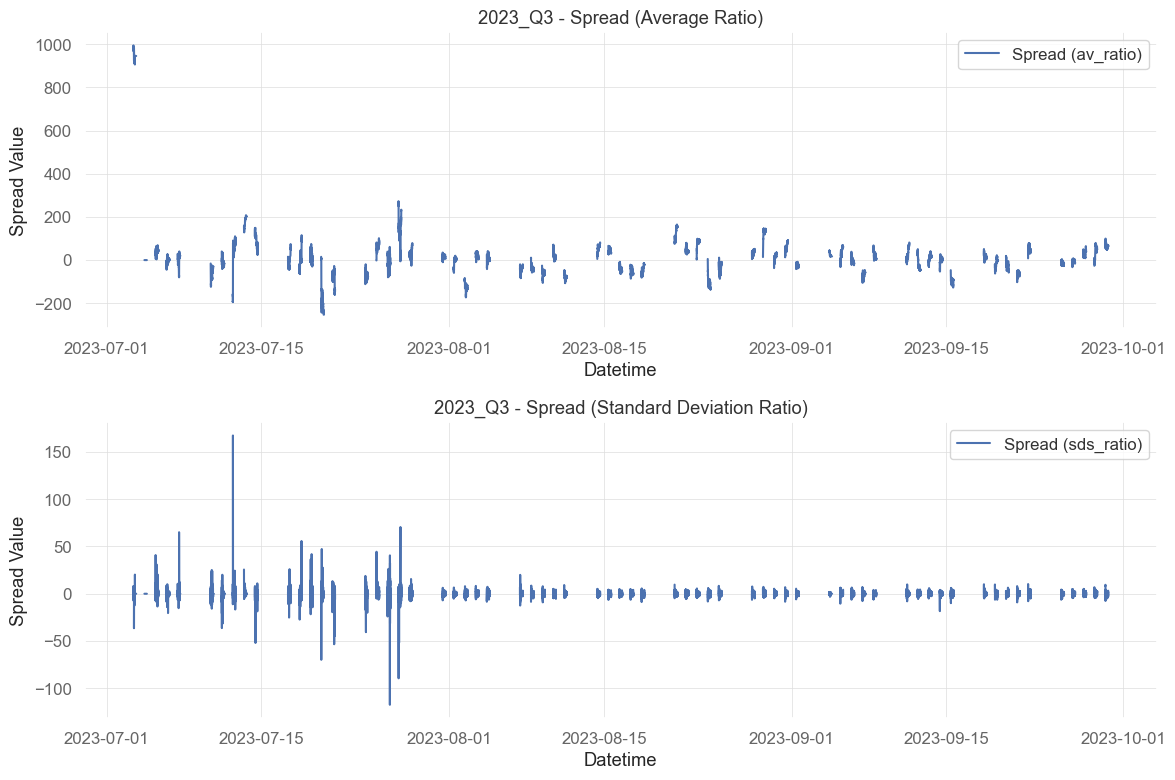

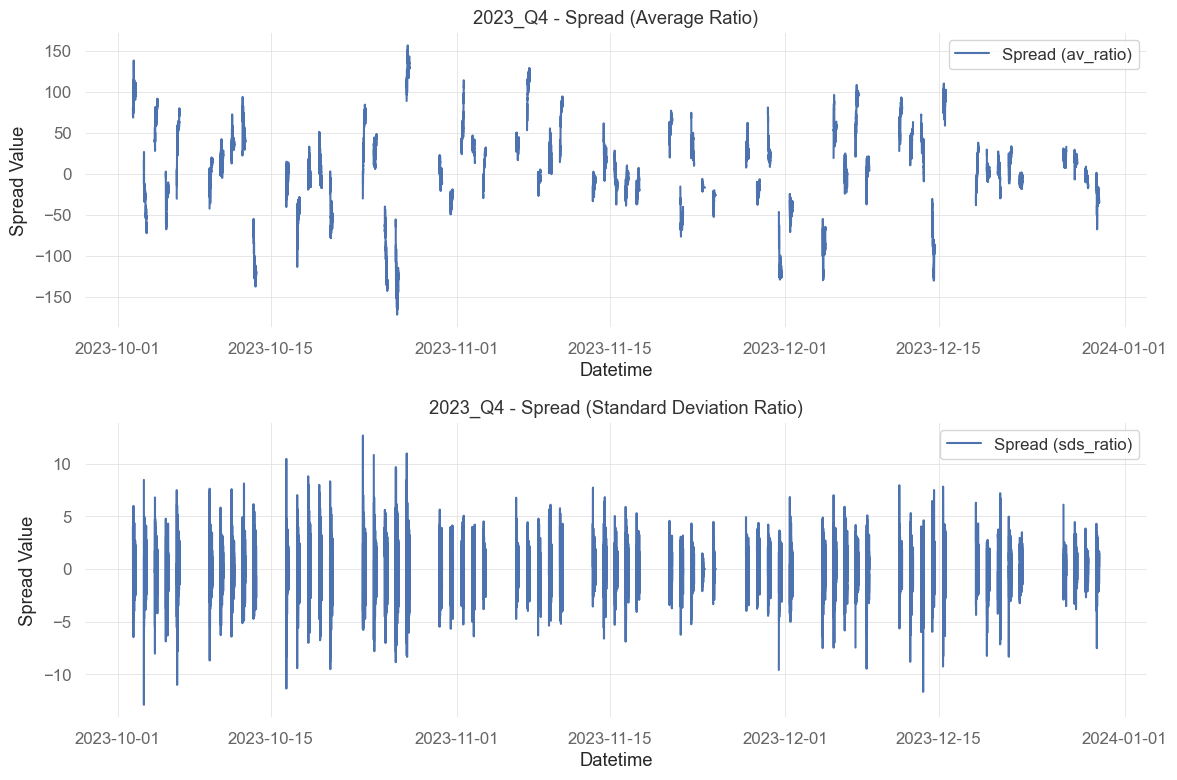

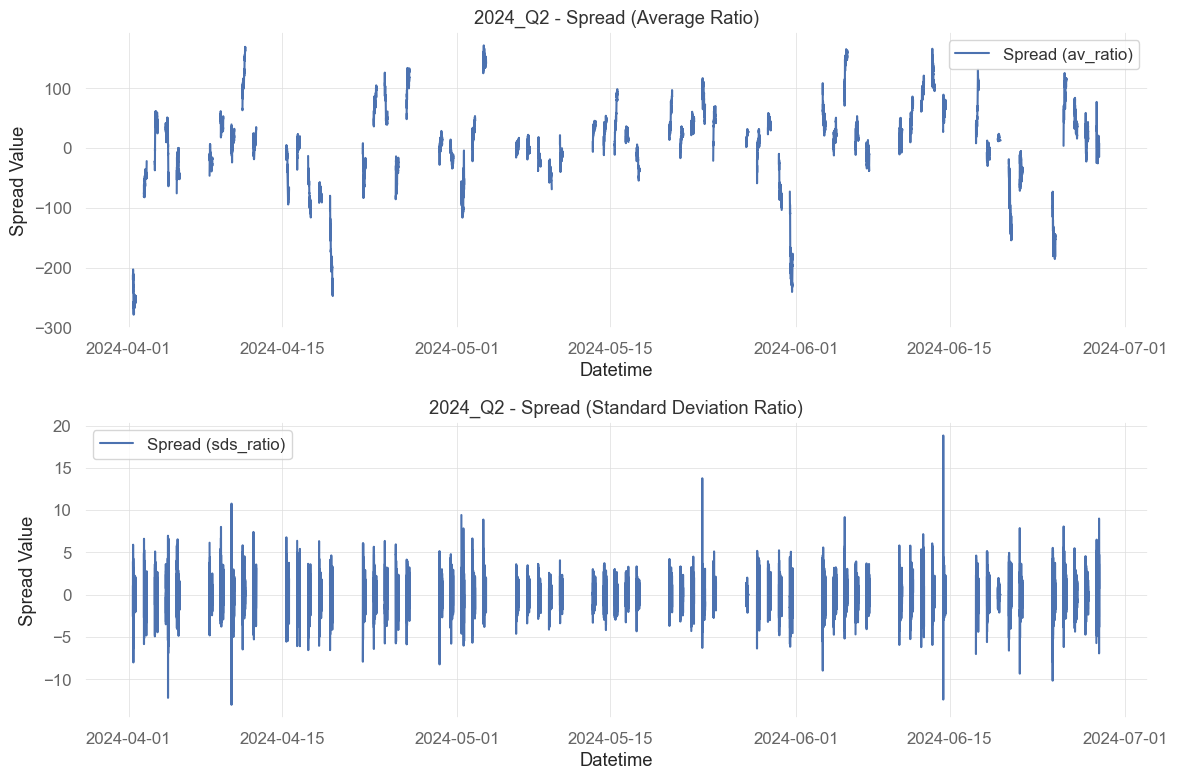

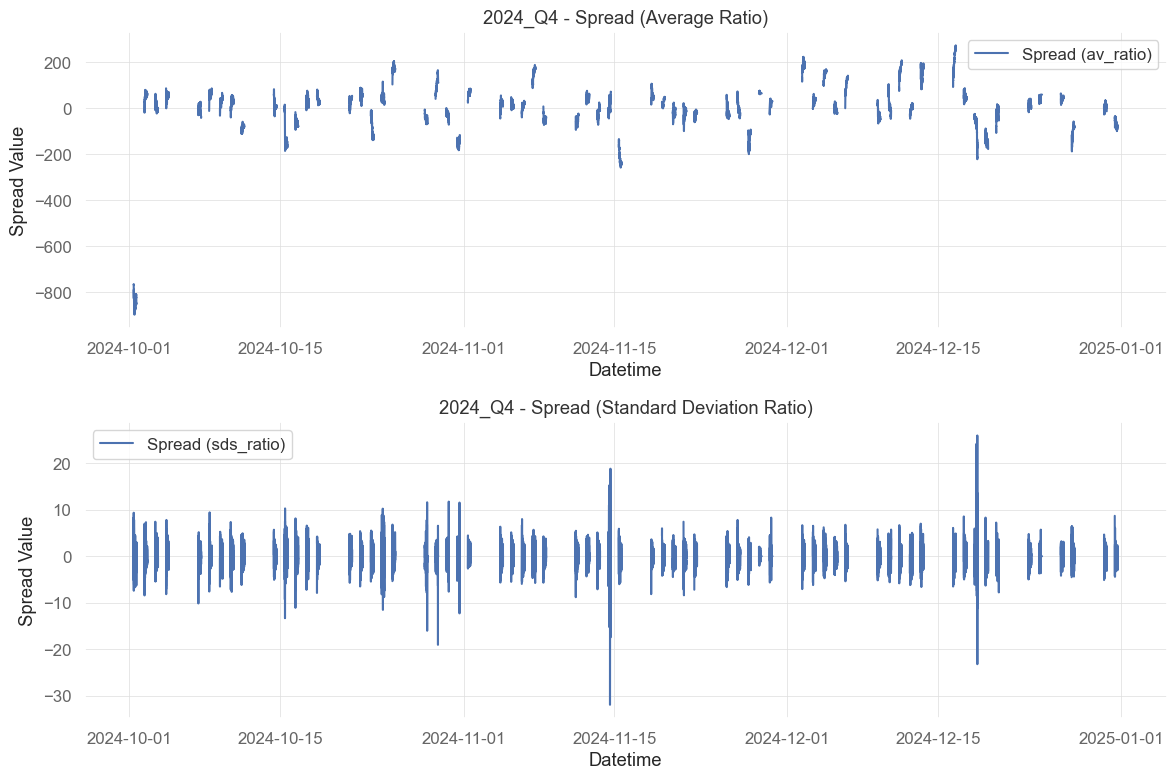

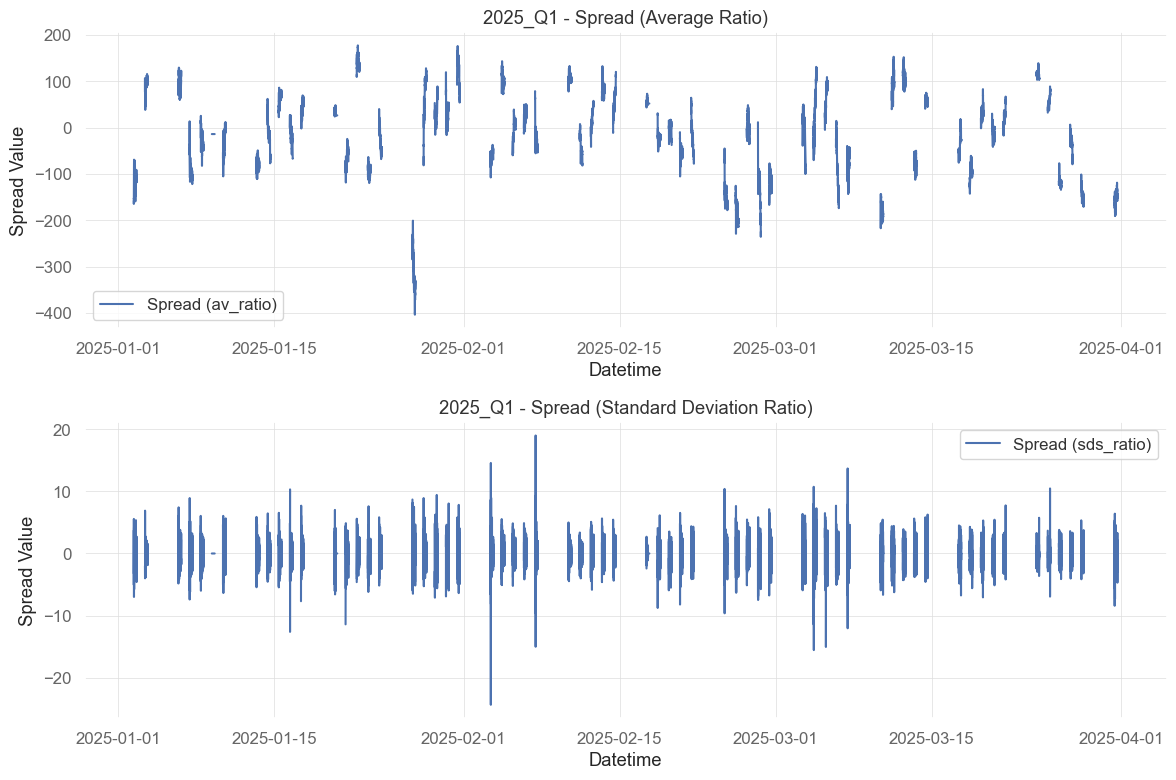

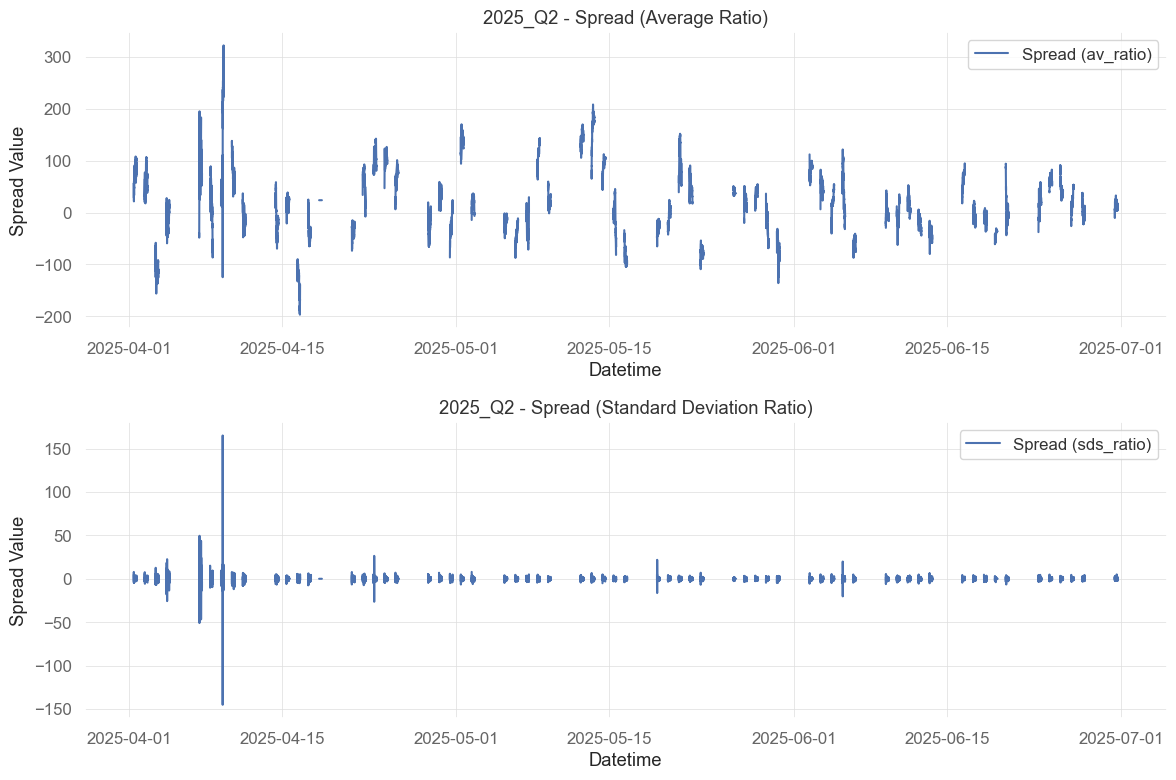

In [82]:
# Create separate charts for each quarter showing both spreads
for quarter in quarters:
    # Filter data for the current quarter
    quarter_data = all_data_2[all_data_2['quarter'] == quarter]
    
    # Create subplots for this quarter
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    # Plot spread based on average ratio
    axes[0].plot(quarter_data.index,
                 quarter_data["spread_avratio"],
                 label="Spread (av_ratio)")
    axes[0].set_title(f"{quarter} - Spread (Average Ratio)")
    axes[0].set_xlabel("Datetime")
    axes[0].set_ylabel("Spread Value")
    axes[0].legend()
    
    # Plot spread based on standard deviation ratio
    axes[1].plot(quarter_data.index,
                 quarter_data["spread_sdsratio"],
                 label="Spread (sds_ratio)")
    axes[1].set_title(f"{quarter} - Spread (Standard Deviation Ratio)")
    axes[1].set_xlabel("Datetime")
    axes[1].set_ylabel("Spread Value")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [83]:
# we assume that spread mean reverts to 0

# lets apply the volatility breakout model

# first we need to calculate the standard deviation of the spreads
# let's use rolling window of 120 minutes (2 hours)

all_data_2["std_spread_avratio"] = all_data_2["spread_avratio"].rolling(window=120).std()
all_data_2["std_spread_sdsratio"] = all_data_2["spread_sdsratio"].rolling(window=120).std()

# lets put missings whenever KO price is missing
# (PEP price should be missing in the same moments)

all_data_2.loc[all_data_2["NQ"].isna(), ["std_spread_avratio", "std_spread_sdsratio"]] = np.nan

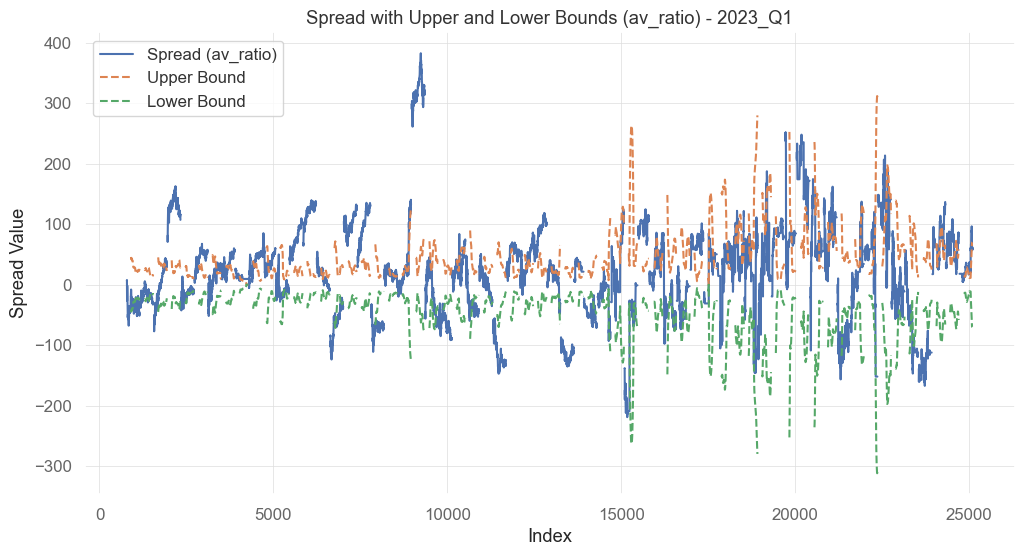

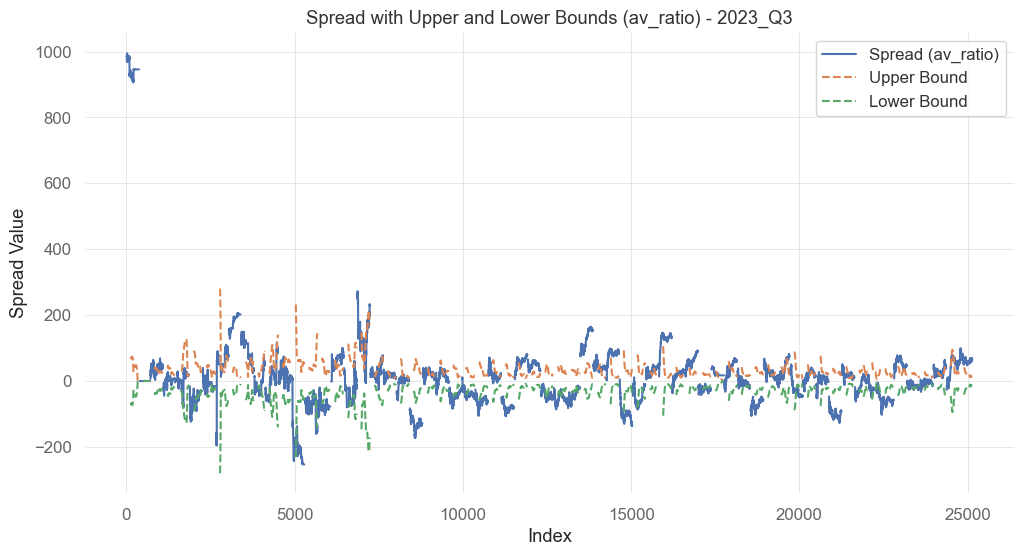

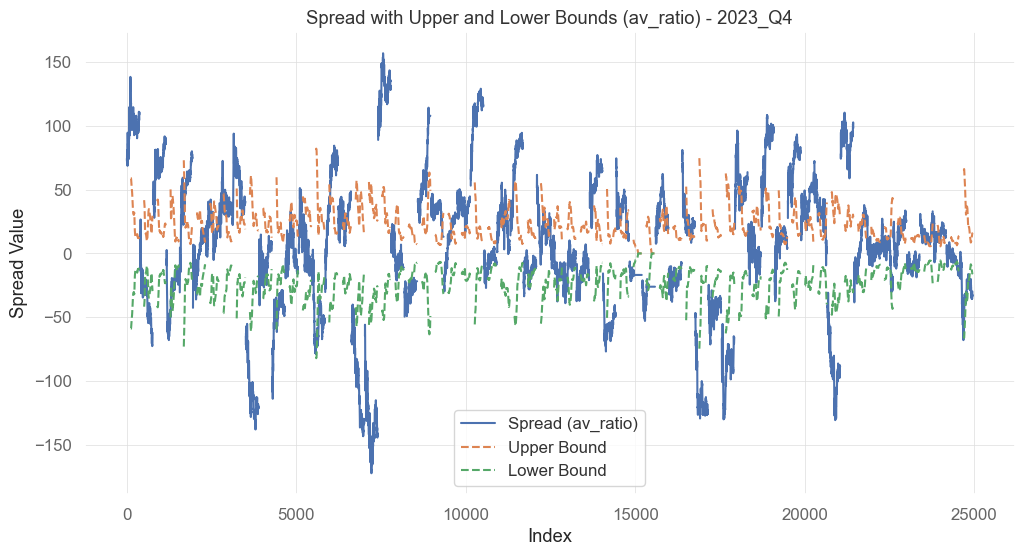

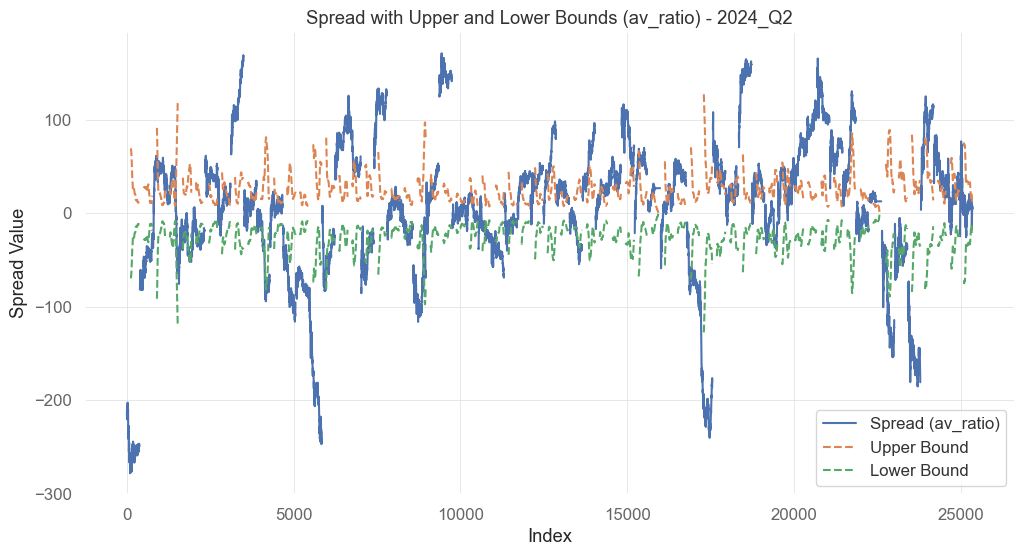

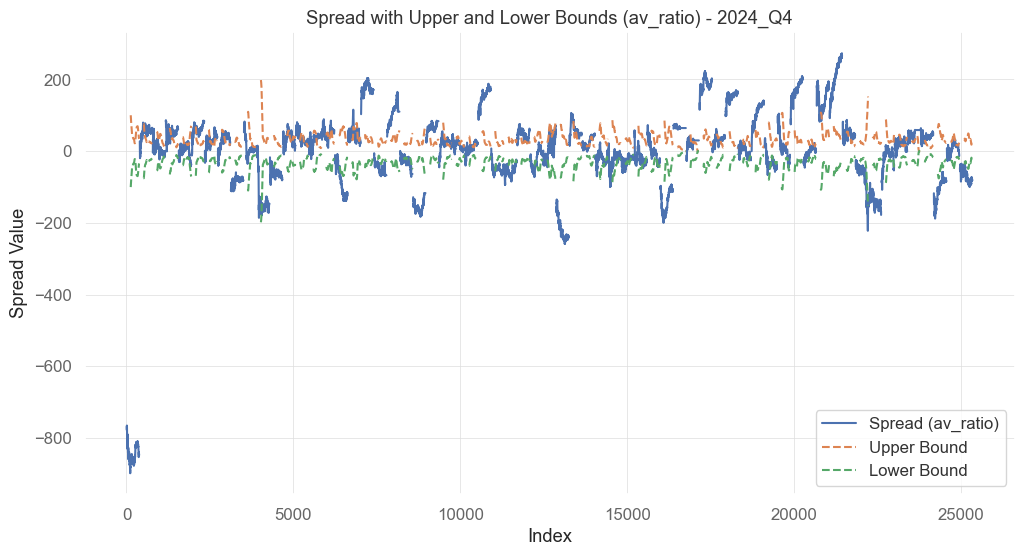

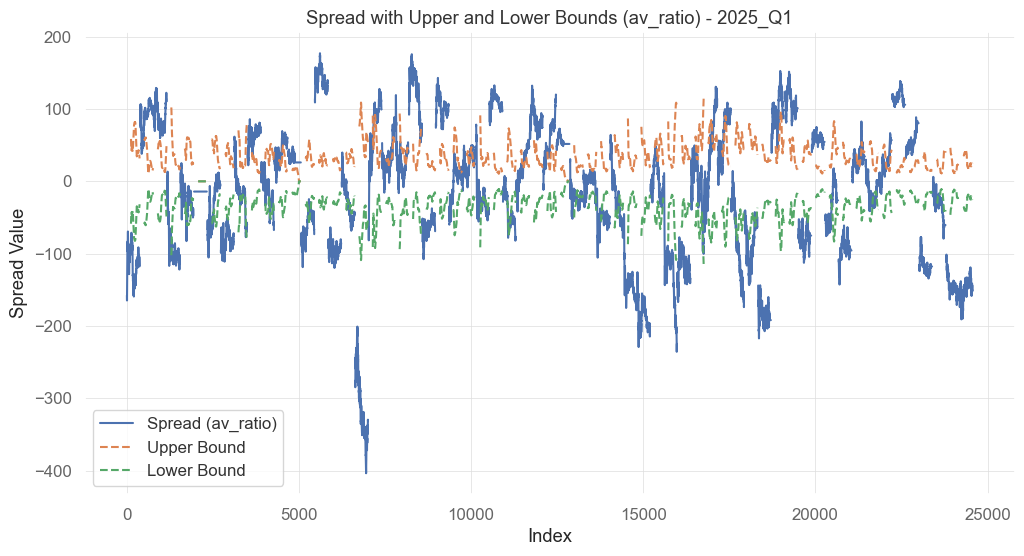

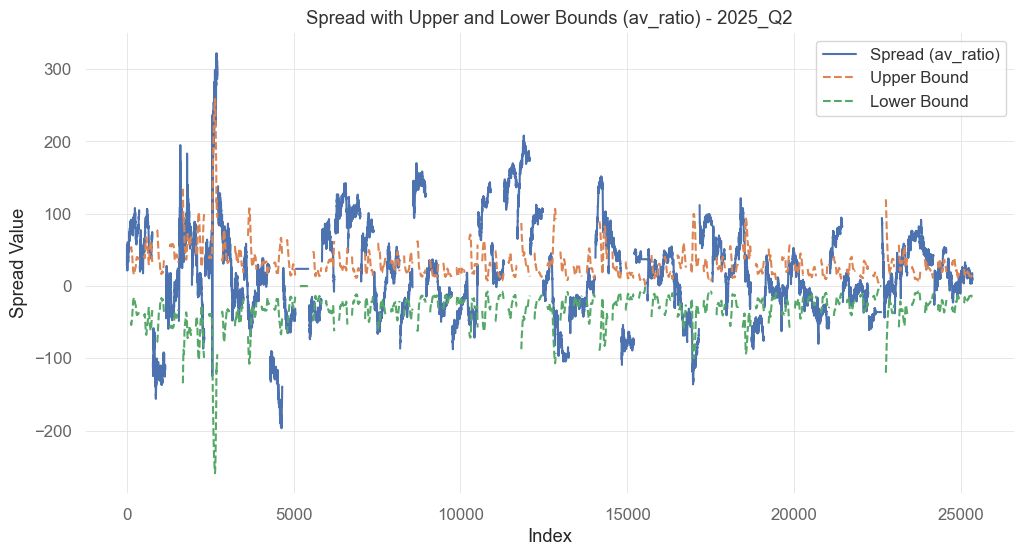

In [86]:
# applying a volatility breakout model
# sample upper and lower bounds for spreads
# for a volatility multiplier of 3
# (here we put the upper and lower band along zero)

all_data_2["upper_bound_avratio"] = 3 * all_data_2["std_spread_avratio"]
all_data_2["lower_bound_avratio"] = -3 * all_data_2["std_spread_avratio"]

# lets see how it looks like for each quarter separately
# Create separate charts for each quarter
for quarter in quarters:
    # Filter data for the current quarter
    quarter_data = all_data_2[all_data_2['quarter'] == quarter]
    
    # Reset index for plotting
    quarter_data_plot = quarter_data.reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(quarter_data_plot.index,
             quarter_data_plot["spread_avratio"],
             label="Spread (av_ratio)")
    plt.plot(quarter_data_plot.index,
             quarter_data_plot["upper_bound_avratio"],
             label="Upper Bound", linestyle='--')
    plt.plot(quarter_data_plot.index,
             quarter_data_plot["lower_bound_avratio"],
             label="Lower Bound", linestyle='--')
    plt.title(f"Spread with Upper and Lower Bounds (av_ratio) - {quarter}")
    plt.xlabel("Index")
    plt.ylabel("Spread Value")
    plt.legend()
    plt.show()

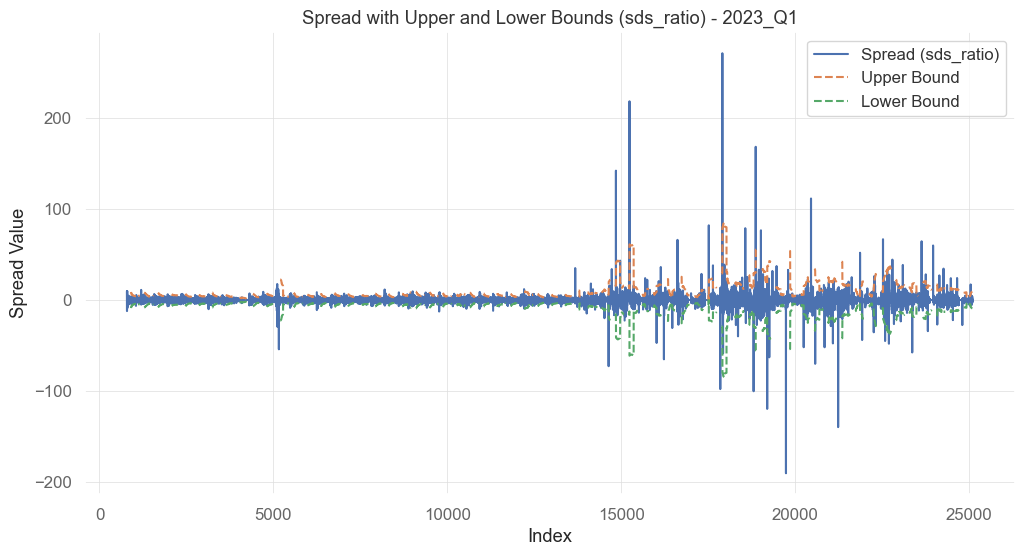

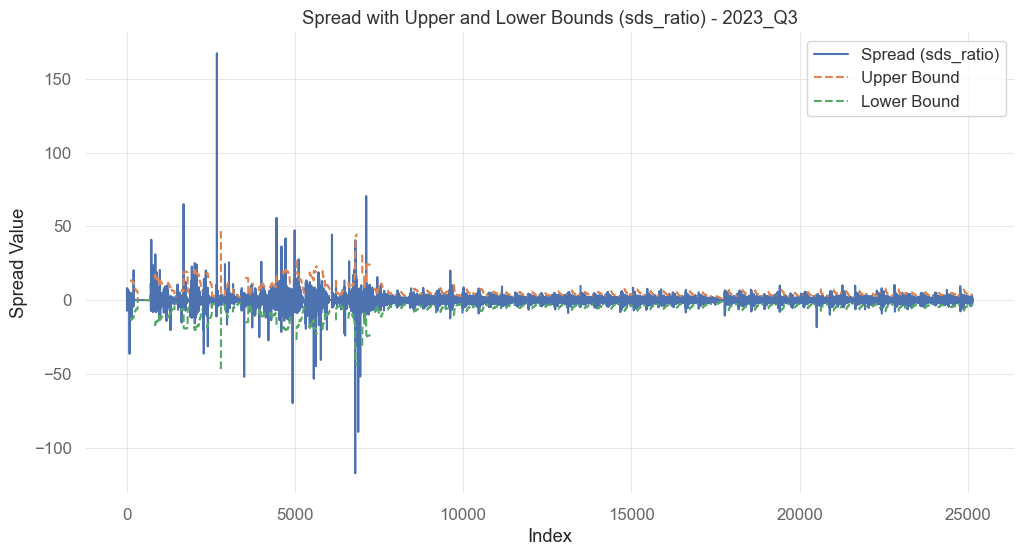

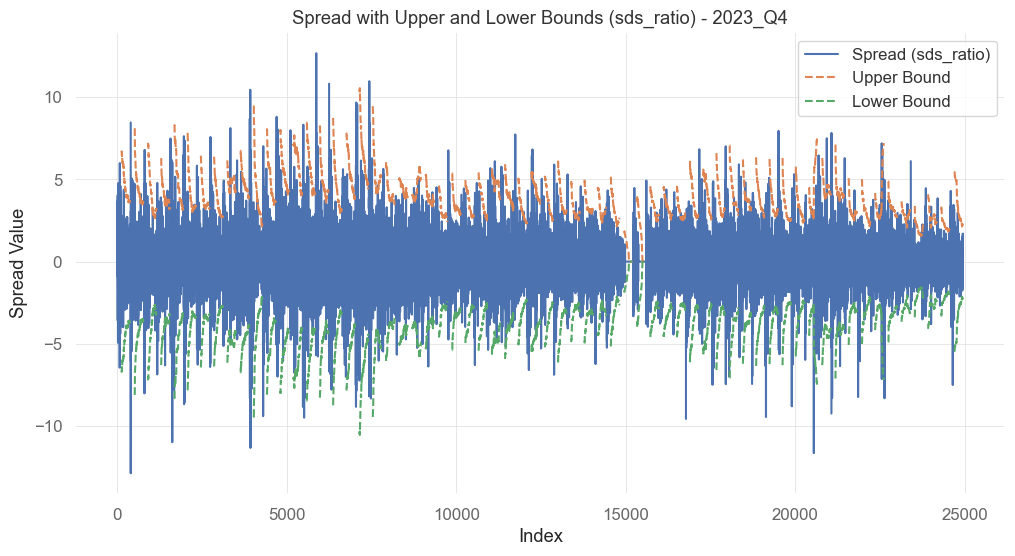

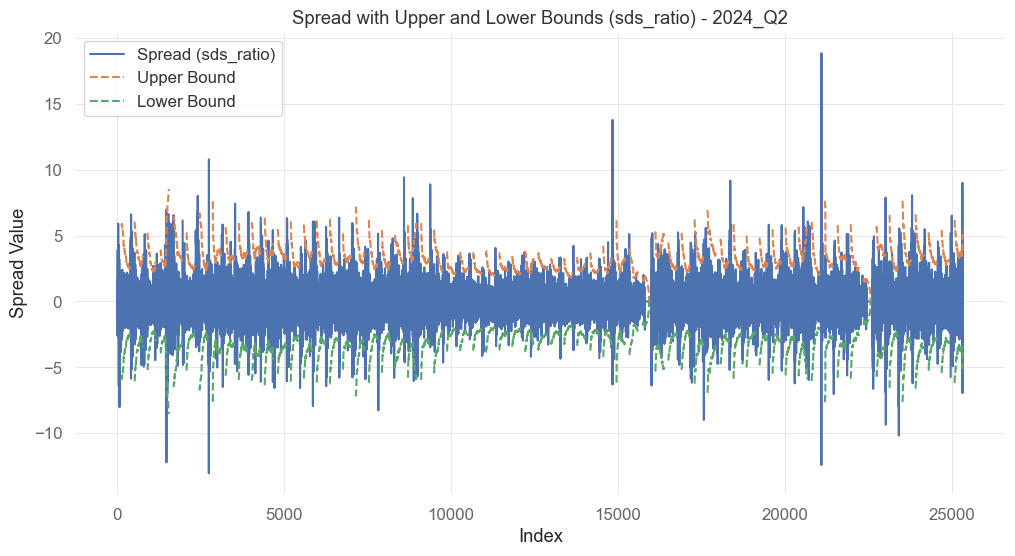

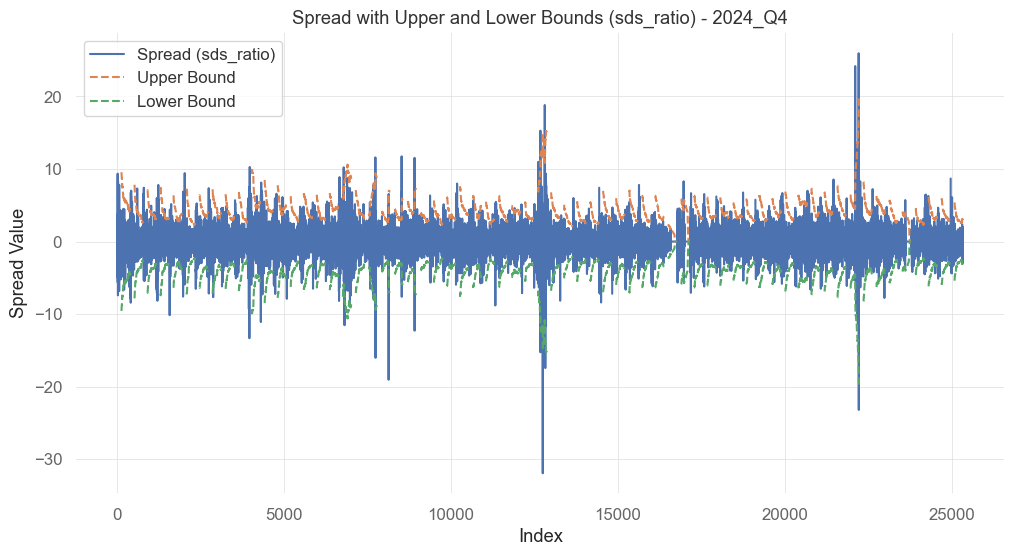

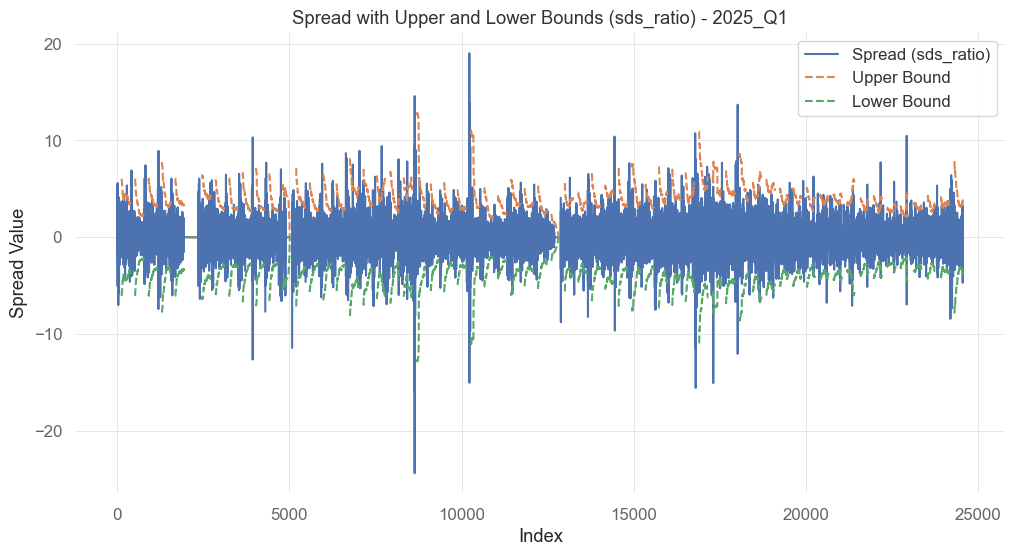

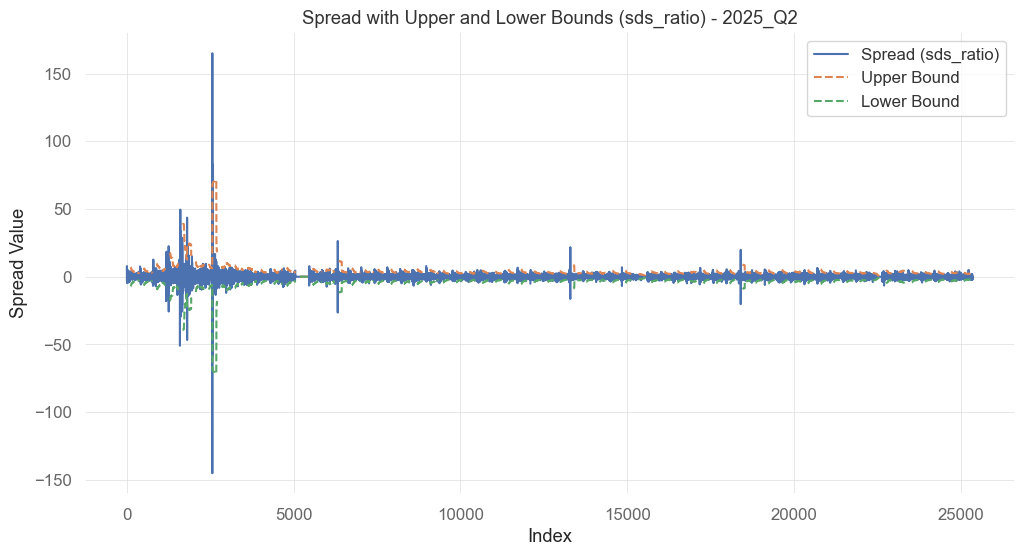

In [87]:
# applying a volatility breakout model
# sample upper and lower bounds for spreads
# for a volatility multiplier of 3
# (here we put the upper and lower band along zero)

all_data_2["upper_bound_sdsratio"] = 3 * all_data_2["std_spread_sdsratio"]
all_data_2["lower_bound_sdsratio"] = -3 * all_data_2["std_spread_sdsratio"]

# lets see how it looks like for each quarter separately
# Create separate charts for each quarter
for quarter in quarters:
    # Filter data for the current quarter
    quarter_data = all_data_2[all_data_2['quarter'] == quarter]
    
    # Reset index for plotting
    quarter_data_plot = quarter_data.reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(quarter_data_plot.index,
             quarter_data_plot["spread_sdsratio"],
             label="Spread (sds_ratio)")
    plt.plot(quarter_data_plot.index,
             quarter_data_plot["upper_bound_sdsratio"],
             label="Upper Bound", linestyle='--')
    plt.plot(quarter_data_plot.index,
             quarter_data_plot["lower_bound_sdsratio"],
             label="Lower Bound", linestyle='--')
    plt.title(f"Spread with Upper and Lower Bounds (sds_ratio) - {quarter}")
    plt.xlabel("Index")
    plt.ylabel("Spread Value")
    plt.legend()
    plt.show()

In [88]:
### position will be based on relation of the spread to volatility bands

# lets assume we do not trade within the first 15-mins of the day
# and exit all positions 15 minutes before the end of quotations

# lets create a pos_flat vector and fill it with 0s

pos_flat = np.zeros(len(all_data_2))

In [89]:
# we do not trade within the first quarter (9:31-9:45)
# but also before that time since midnight

pos_flat[all_data_2.index.time <= pd.to_datetime("9:55").time()] = 1

# and last quarter of the session (15:46-16:00)
# but also after this time until midnight

pos_flat[all_data_2.index.time >= pd.to_datetime("15:40").time()] = 1

# !!! there are no weekends in our data, so we do not need
# to control for that in pos_flat

pd.Series(pos_flat).value_counts()

0.0    155097
1.0     20715
Name: count, dtype: int64